# encoder-GAN learnable latent mapping

### Description of idea

There exists problem of GAN inversion, where we want to learn a map to latent codes of GAN, which ultimately enables us to edit images in latent space and produce transitions from one another.

What we want to try is to utilize latent space of pretrained encoder, which was trained in ss contrastive manner (cause we know that it's latent space is great). We want to learn mapping $m(\cdot)$ from latent space of this encoder to latent space of encoder to latent space of GAN. 

We also propose a new pipeline for this kind of training. Usually there exists a complex pipeline starting from image which is encoded into latent, then mapped, then decoded by GAN into generated image. This pipeline suggest usage of complex 'consistency' losses, which account for reconstruction of image being inverted from latent codes. Instead we suggest to start from latent codes, generate an image and then encode it. This naturally eliminates needs for any consistency loss, as we are operating purely on latents.

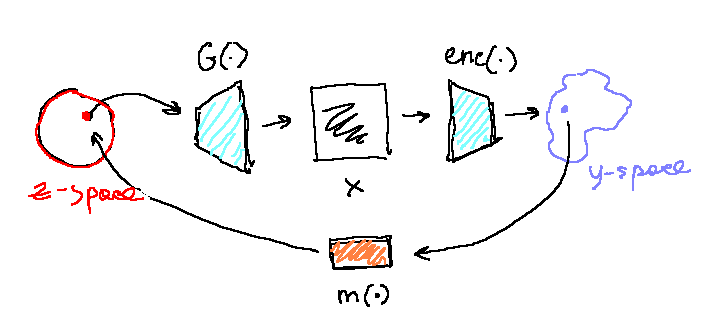

Here, only mapping $m(\cdot)$ is trainable, everything else is pretrained and fixed!

## Simplest experiment with MNIST dataset

For our simplest experiment, we need to obtain two things

- generator $G(\cdot)$ from GAN training on MNIST
- self-supervised trained encoder $enc(\cdot)$, also trained on MNIST

After that, we are ready to learn our mapping $m(\cdot)$.

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# !pip install lightly -q

In [1]:
from train_gan import Generator
from train_encoder import SimCLR

import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

from utils import *

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value

In [10]:
from pathlib import Path
dir_models = Path('models/')
dir_models.mkdir(exist_ok=True)

dir_logs = Path('logs')
dir_logs.mkdir(exist_ok=True)

In [11]:
# !wget https://github.com/csinva/gan-vae-pretrained-pytorch/raw/master/mnist_dcgan/weights/netG_epoch_99.pth  -O models/mnist_gan.pth -q

In [2]:
z_dim=100
y_dim=512

class M(nn.Module):
    """Learnable projection from y-space to z-space"""
    def __init__(self, n_hidden_layers, hidden_dim, y_dim, z_dim):
        super().__init__()
        layers = [nn.Linear(y_dim, hidden_dim)]
        for _ in range(n_hidden_layers):
            layers += [nn.GELU(), nn.Linear(hidden_dim, hidden_dim)]
        layers += [nn.GELU(), nn.Linear(hidden_dim, z_dim)]
        self.projection = nn.Sequential(*layers)

    def forward(self, y):
        return self.projection(y)

In [12]:
G = Generator().to(DEVICE)

resnet = torchvision.models.resnet18()
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
E = nn.Sequential(*list(resnet.children())[:-1]).to(DEVICE)

G.load_state_dict(torch.load("models/mnist_gan.pth"))
# E.load_state_dict(torch.load("models/encoder_mnist.pth"))
                  
for p in G.parameters():
    p.requires_grad = False

# for p in E.parameters():
#     p.requires_grad = False

In [20]:
holdout_mnist = MNIST(root="data", train=False, download=True, transform=T.Compose([
    T.Resize(28),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
]))

# evaluation samples are used to check that enc(img) -> y -> m(y) -> G(m(y)) is a valid inversion
eval_samples = torch.stack([holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]).to(DEVICE)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1821095.30it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 245041.33it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1880608.17it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2272790.36it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



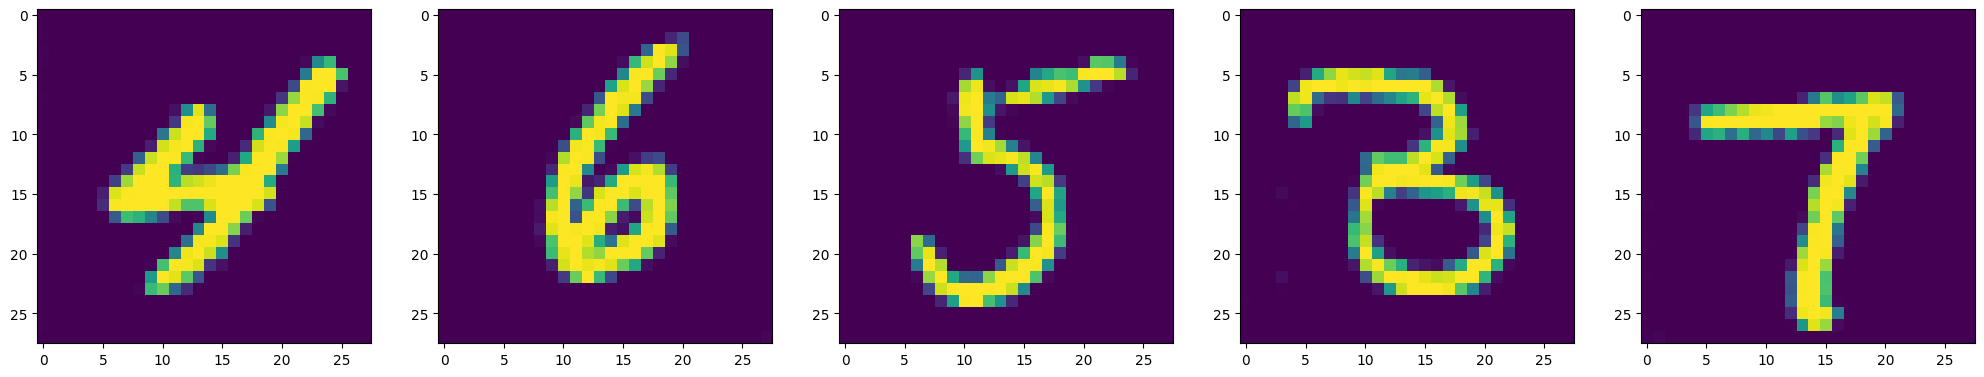

In [21]:
# gan quality sanity check
z = torch.randn((5, z_dim), device=DEVICE)
with torch.no_grad():
    images = G(z[:,:, None, None])

images = images.detach().cpu().numpy()
_, axs = plt.subplots(1, 5, figsize=(25, 10))
for (ax, img) in zip(axs, images):
    ax.imshow(img.reshape((28, 28)))

In [23]:
import torchvision.transforms as T

def train_latent_map(
        mapping: nn.Module, 
        generator: nn.Module, 
        encoder: nn.Module, 
        loss_fn, # loss function used on latents
        optimizer, 
        num_iters=5000, 
        eval_iters=1000, 
        batch_size=512, 
        loss_rec=None,
        ema=None,
        image_augmentations=None,
        args=AttributeDict()
    ):
    generator.eval()
    encoder.eval()
    mapping.train()


    loss_hist = []
    p_bar = tqdm(range(num_iters))
    for i in p_bar:
        optimizer.zero_grad()
        
        z = torch.randn((batch_size, z_dim), device=DEVICE)
        
        with torch.no_grad():
            images = G(z[:,:, None, None])

            if image_augmentations is not None:
                images = image_augmentations(images)
            
            y = E(images).squeeze()

            if args.noise_lantents:
                y += args.nl_scale*torch.randn_like(y)
        
        if args.adv_loss_used:
            loss = loss_fn(mapping, y, z)
        else:
            z_hat = mapping(y)
            loss = loss_fn(z_hat, z)

        if loss_rec is not None:
            imgs_hat = G(z_hat[:, :, None, None])
            loss += args.rec_loss_scale * loss_rec(imgs_hat, images)
        
        loss.backward()
        optimizer.step()
        if ema is not None:
            ema.update()
        
        loss_hist.append(loss.item())
        p_bar.set_postfix(loss=loss.item())

    return loss_hist


@torch.no_grad()
def visualize_inversion(eval_samples, mapping, saved_weights_path=None):
    if saved_weights_path is not None:
        mapping.load_state_dict(torch.load(saved_weights_path))
    mapping.eval()
    y = E(eval_samples).squeeze()
    z_hat = mapping(y)[:,:, None, None]
    inv_samples = G(z_hat)

    _, axs = plt.subplots(2, 5, figsize=(25, 10))
    for i in range(5):
        img_orig = eval_samples[i].cpu().numpy().reshape((28, 28))
        img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
        axs[0][i].imshow(img_orig)
        axs[1][i].imshow(img_invers)
    plt.show()

### Image masking + trying inpainting

Results: kinda works, although inpaining validation should be re-implemented

Correct algorithm: mask image, produce $G(\hat z)$, substitute masked region with generation result

In [8]:
from torchvision import transforms as T

args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 0.


mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)

masking_loss_hist = train_latent_map(
    mapping, 
    generator=G, 
    encoder=E, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    image_augmentations=T.RandomErasing(),
    args=args
)

torch.save(mapping.state_dict(), f"models/masking/mapping_{n_hidden}_{hidden_dim}.pth")

NameError: name 'n_hidden' is not defined

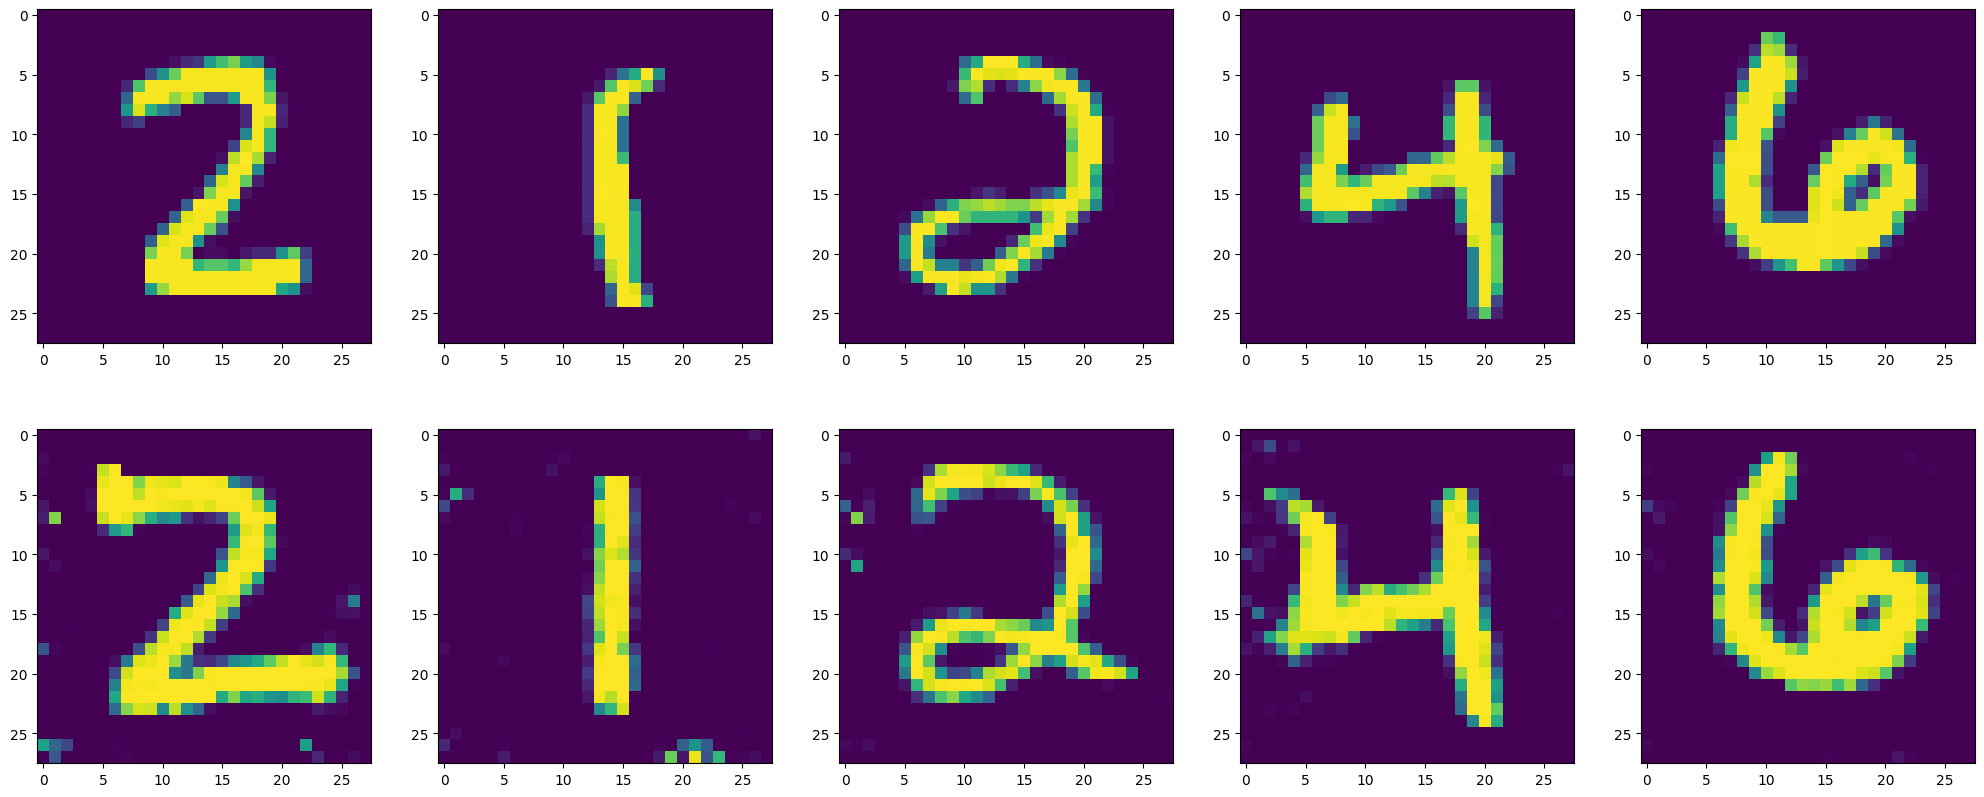

In [92]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/masking/mapping_3_128.pth")

Let's look at actual inpainting results (actually not in-painting, since we are looking at complete generation, without substituting regenerated region)

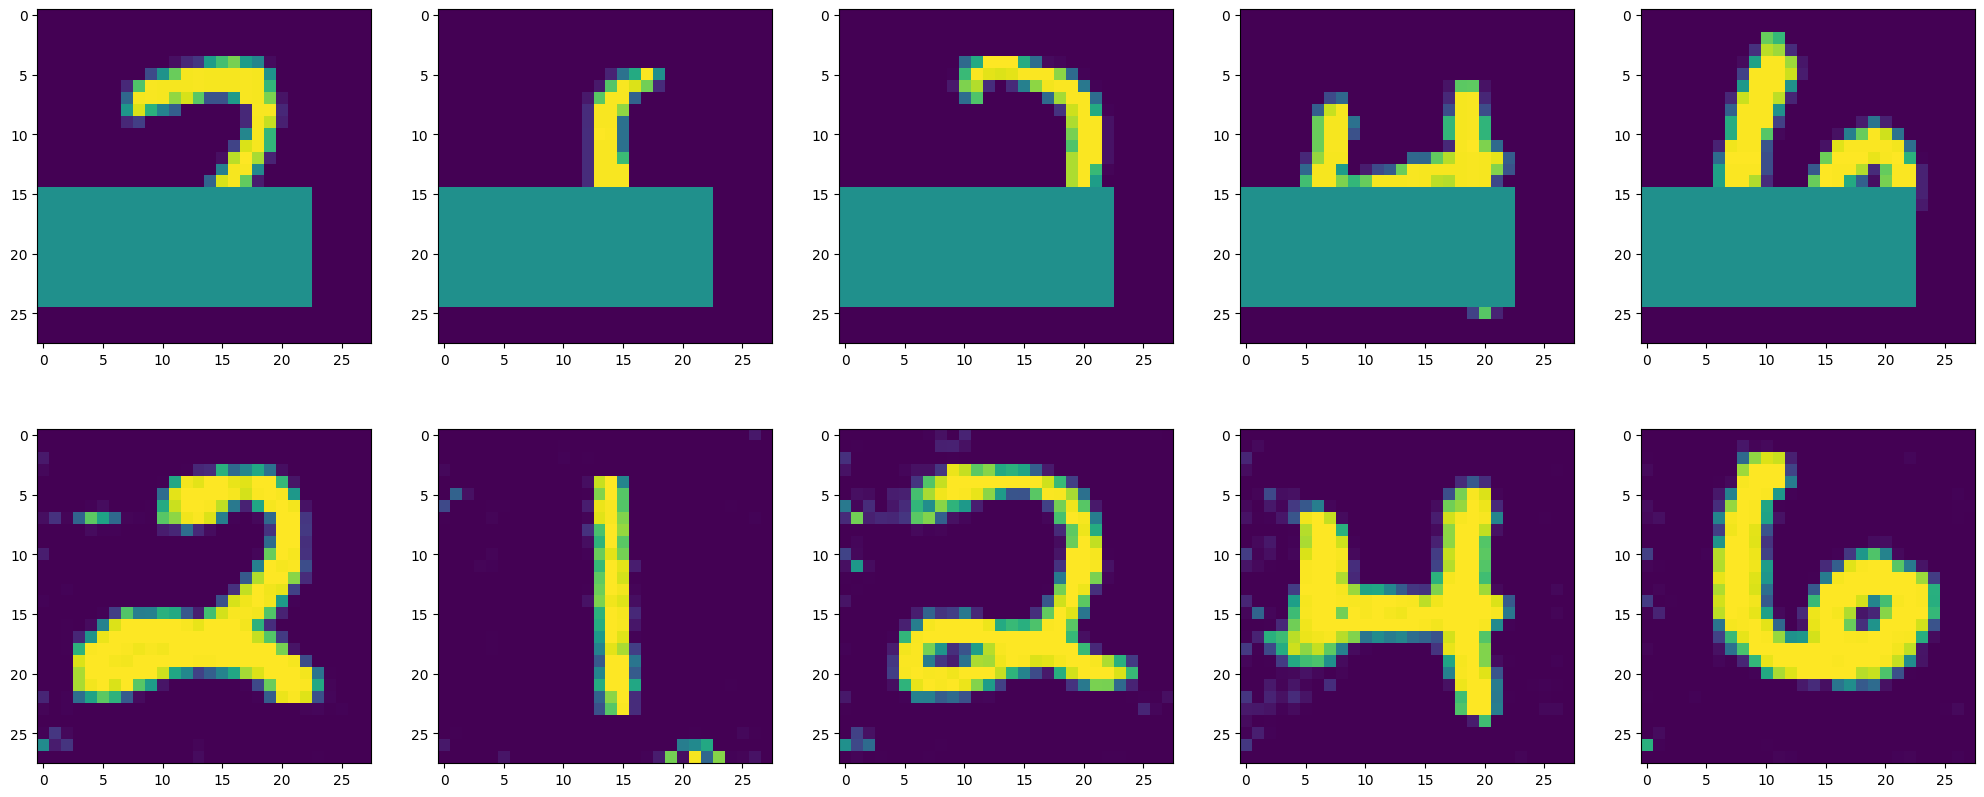

In [113]:
masked_eval_samples = T.RandomErasing(p=1.)(eval_samples)
visualize_inversion(masked_eval_samples, mapping, saved_weights_path="models/masking/mapping_3_128.pth")

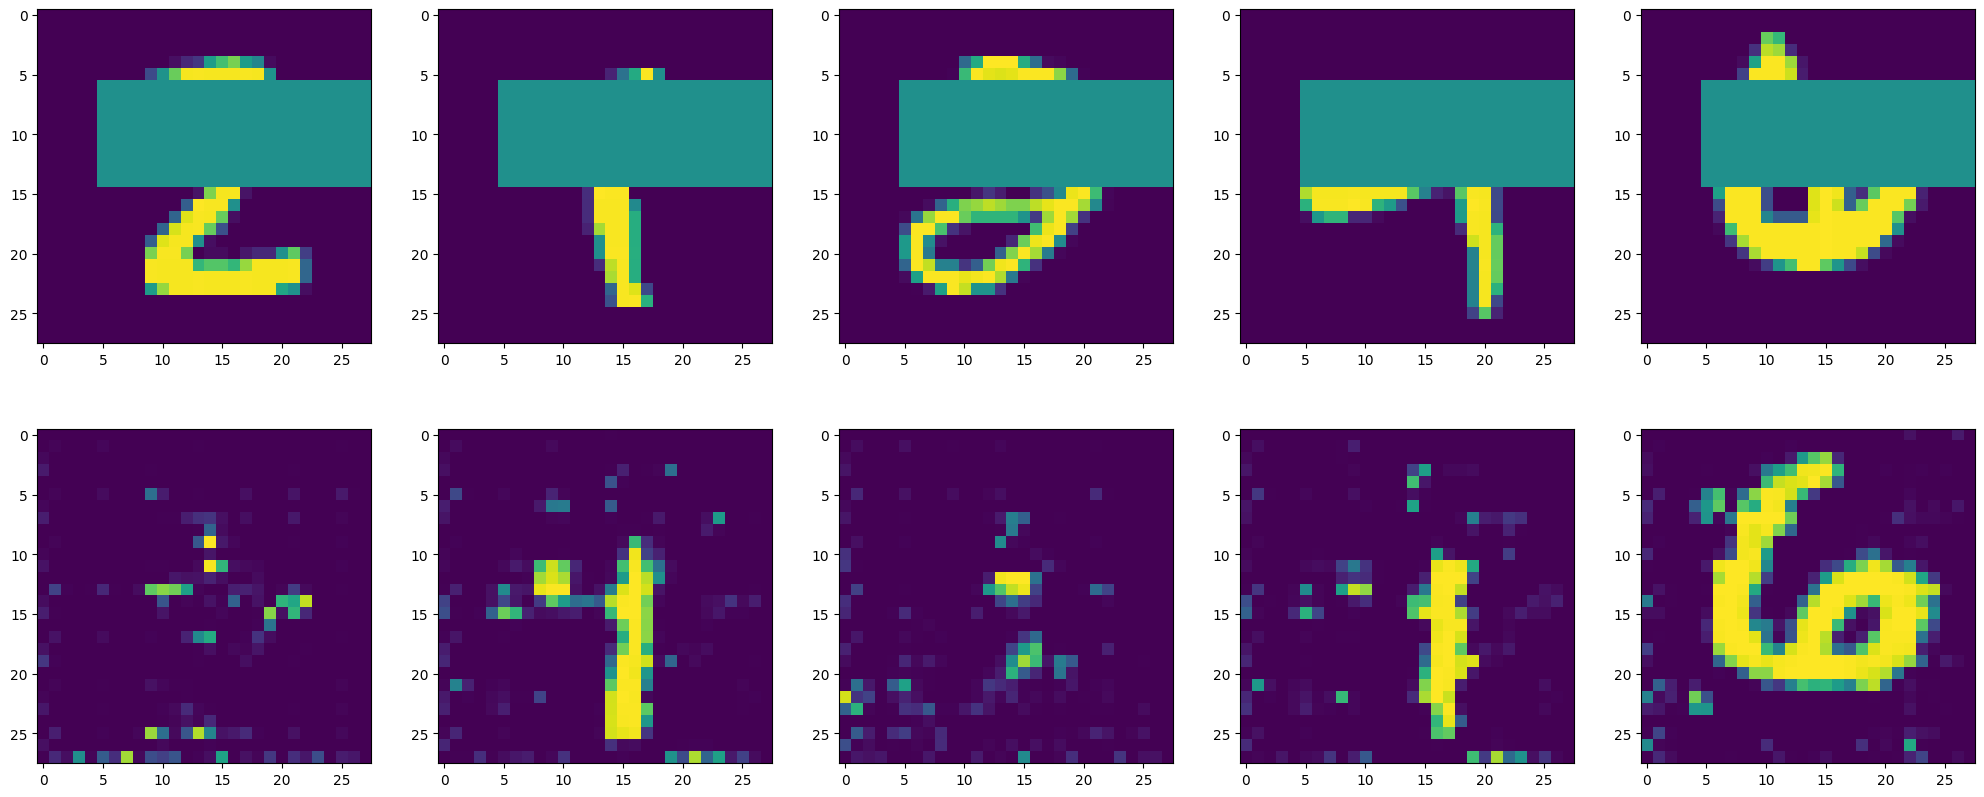

In [105]:
# let's add random masks and see is in-painting possible
masked_eval_samples = T.RandomErasing(p=1.)(eval_samples)
visualize_inversion(masked_eval_samples, mapping, saved_weights_path="models/masking/mapping_3_128.pth")

Additionally let's try add reconstruction loss + ema to see how it affects masking training

In [114]:
from torch_ema import ExponentialMovingAverage as EMA
from torchvision import transforms as T

args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 1.


mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)
ema = EMA(mapping.parameters(), decay=0.995)

masking_rec_loss_hist = train_latent_map(
    mapping, 
    generator=G, 
    encoder=E, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    loss_rec=F.mse_loss,
    ema=ema,
    image_augmentations=T.RandomErasing(),
    args=args
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:30<00:00, 15.14it/s, loss=1.1]


In [116]:
with ema.average_parameters():
    torch.save(mapping.state_dict(), f"models/masking/mapping_{n_hidden}_{hidden_dim}_rec_ema.pth")

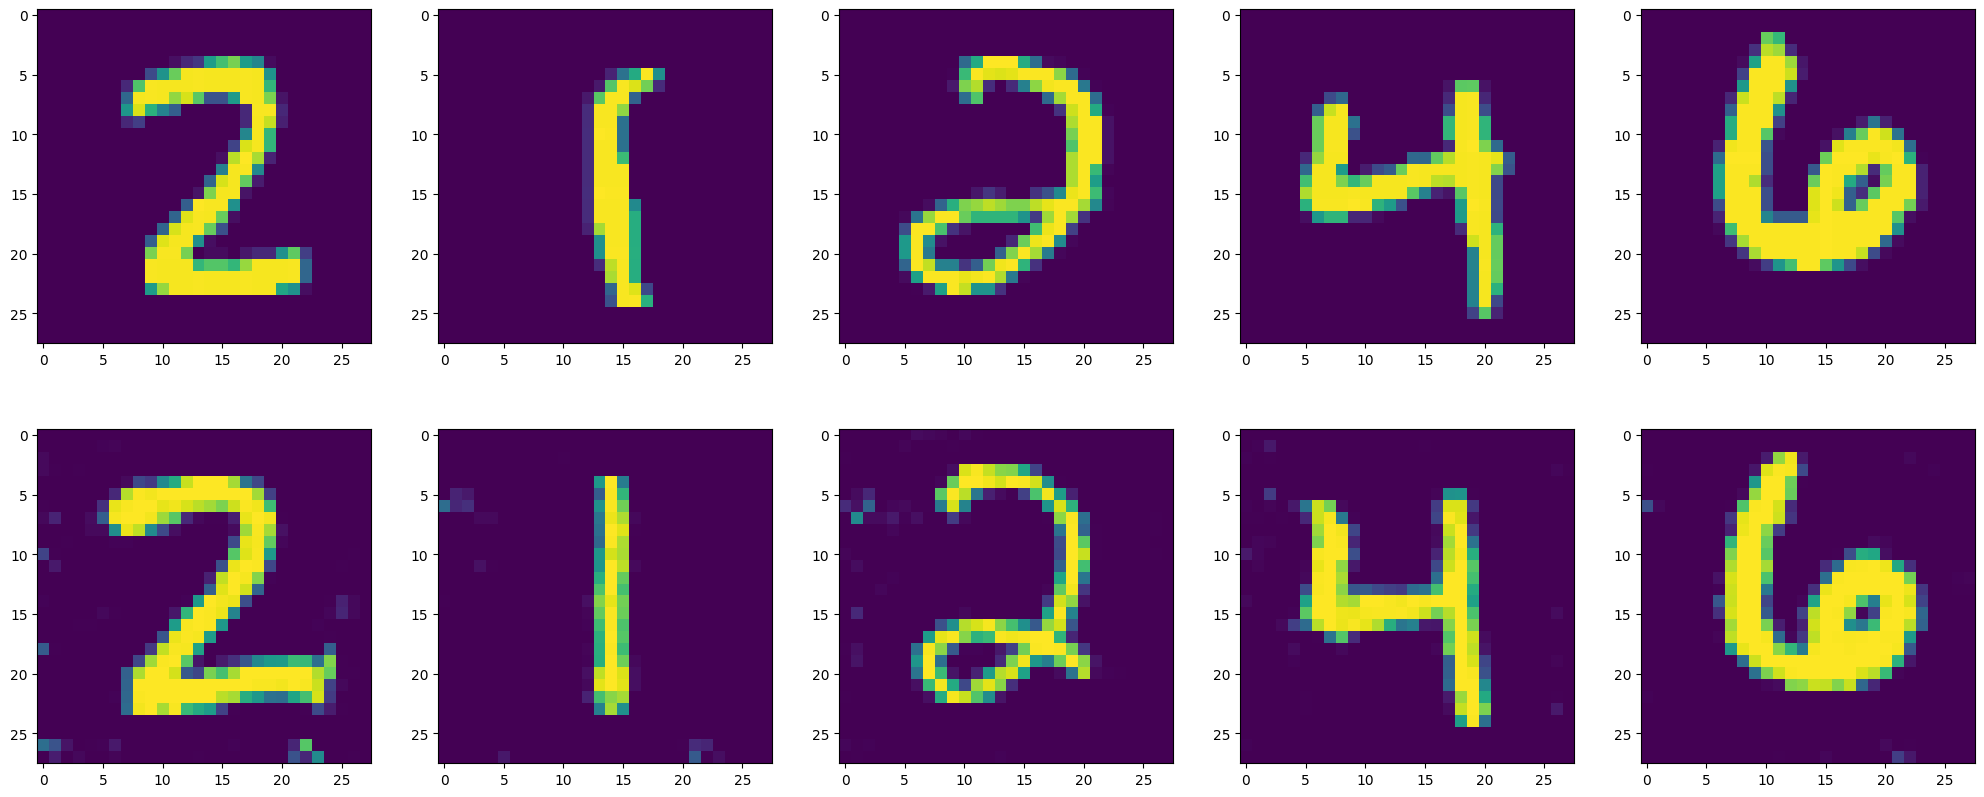

In [117]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/masking/mapping_3_128_rec_ema.pth")

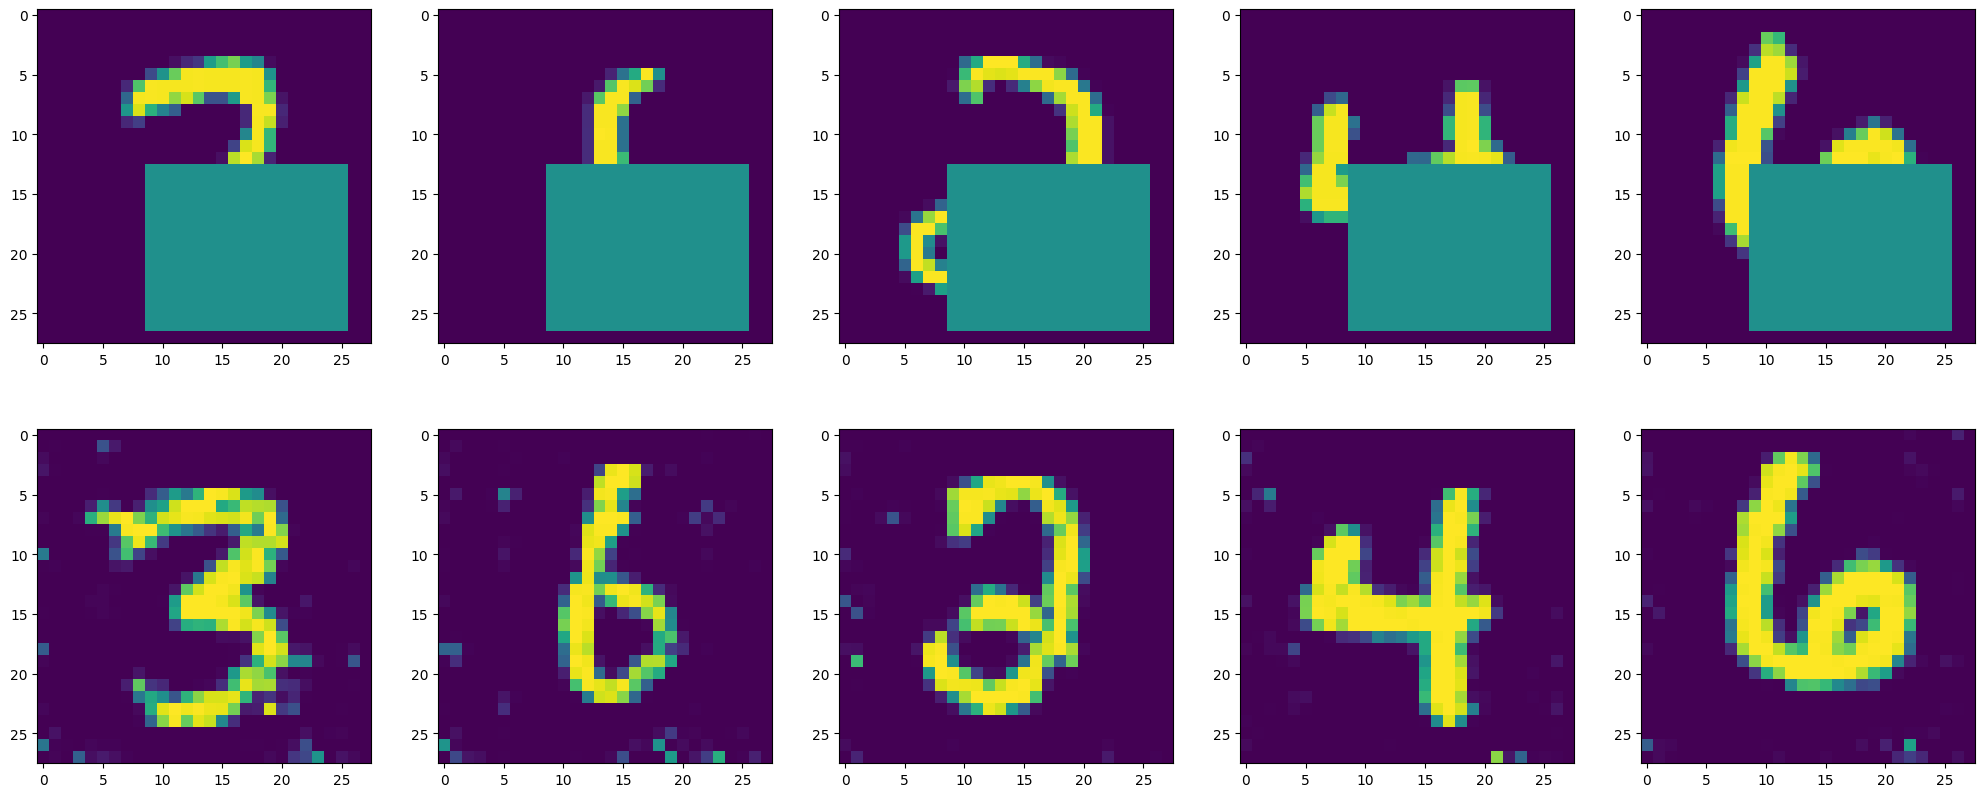

In [122]:
masked_eval_samples = T.RandomErasing(p=1.)(eval_samples)
visualize_inversion(masked_eval_samples, mapping, saved_weights_path="models/masking/mapping_3_128_rec_ema.pth")

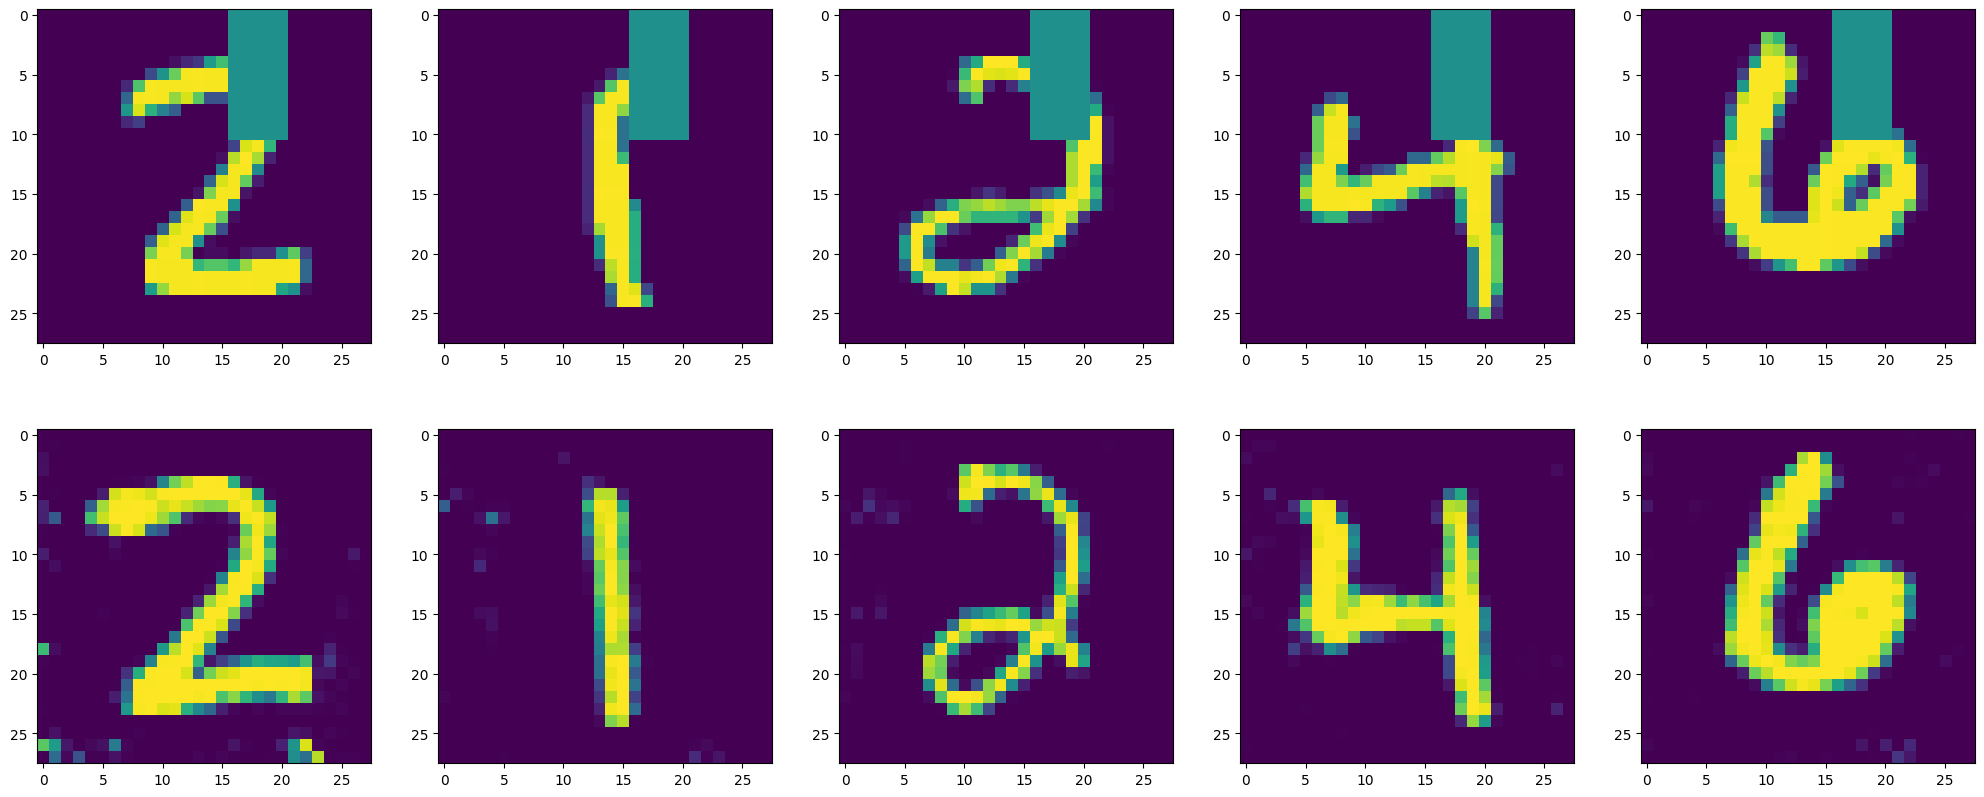

In [123]:
masked_eval_samples = T.RandomErasing(p=1.)(eval_samples)
visualize_inversion(masked_eval_samples, mapping, saved_weights_path="models/masking/mapping_3_128_rec_ema.pth")

### Let's add EMA

Loss is kind of noisy. Meaning invididual updates are not that important in late training. EMA should help

Results: it's hard to tell :)))) At least it doesn't make things worse (also Korotin said it "always" make things better in generative models, and their losses are also unstable

In [79]:
!pip install -q torch-ema

In [ ]:
from torch_ema import ExponentialMovingAverage as EMA

args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 0.


mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)
ema = EMA(mapping.parameters(), decay=0.995)

_ = train_latent_map(
    mapping, 
    generator=G, 
    encoder=E, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    ema=ema,
    args=args
)

In [84]:
with ema.average_parameters():
    torch.save(mapping.state_dict(), f"models/mapping_{n_hidden}_{hidden_dim}_ema.pth")

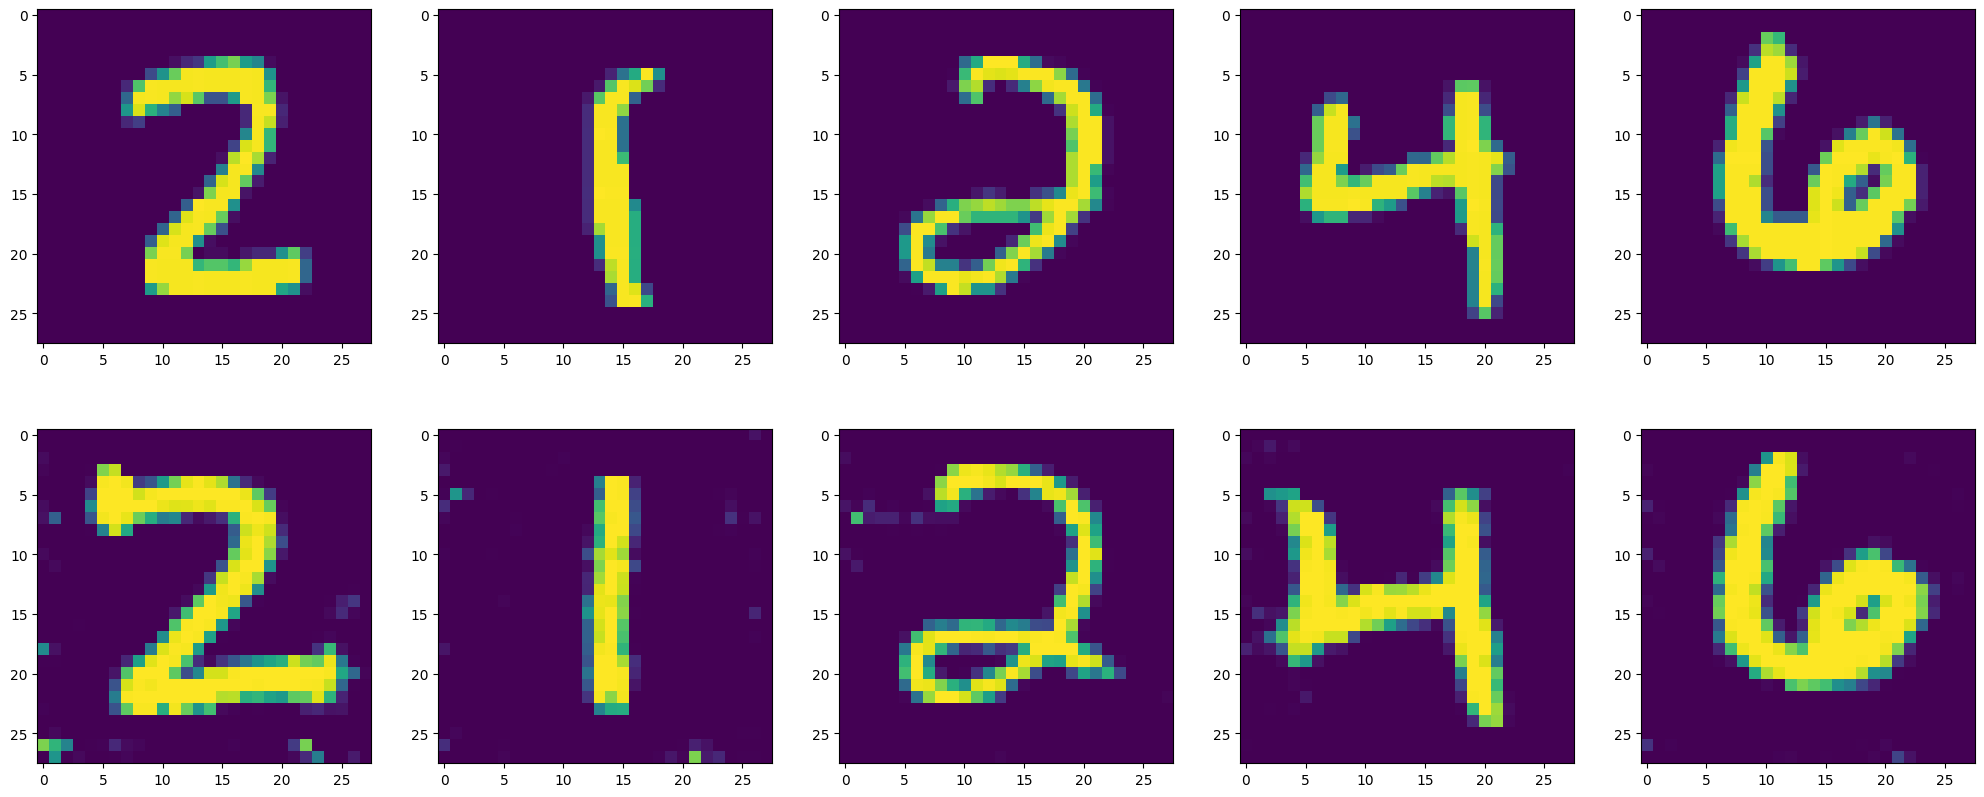

In [86]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/mapping_3_128_ema.pth")

### Trying other loss functions than MSE

Results:
- cosine loss produces nonsense
- adversarial training with MSE explodes, weight_decay doesn't help
- l1 loss is not significantly different from l2


In [74]:
from utils import fgsm, pgd_linf, plot_losses

def cosine_sim_loss(z_pred: torch.Tensor, z_targ: torch.Tensor):
    return -F.cosine_similarity(z_pred, z_targ, dim=1).abs().mean()


def aversarial_loss(model, y, z_target, loss_fn=F.mse_loss, **kwargs):
    # produce find attack perbutation
    delta = pgd_linf(mapping, y, z_target, **kwargs)
    # get pertubed predictions and calculate loss
    z_pred = model(y + delta)
    return loss_fn(z_pred, z_target)
    

In [56]:
args = AttributeDict()
args.apply_augment = False
args.apply_masking = False
args.noise_lantents = False
args.apply_rec_loss = False
args.adv_loss_used = False
args.rec_loss_scale = 0.


mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)

cosine_loss_hist = train_latent_map(
    mapping, 
    generator=G, 
    encoder=E, 
    loss_fn=cosine_sim_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    args=args
)

torch.save(mapping.state_dict(), f"models/lat_losses/mapping_{n_hidden}_{hidden_dim}_cosine.pth")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:10<00:00, 26.27it/s, loss=-0.256]


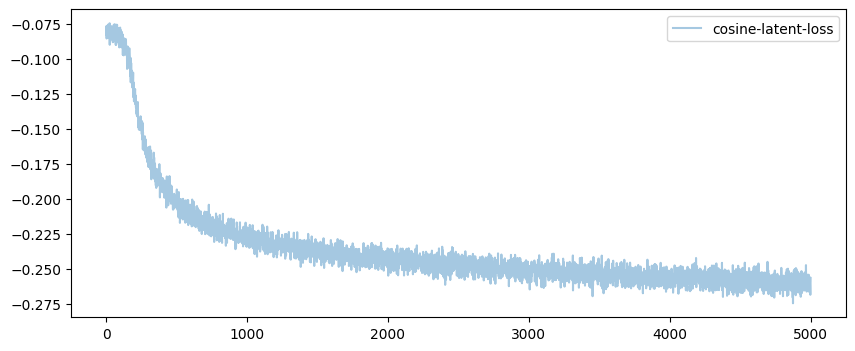

In [77]:
plot_losses({"cosine-latent-loss": cosine_loss_hist})

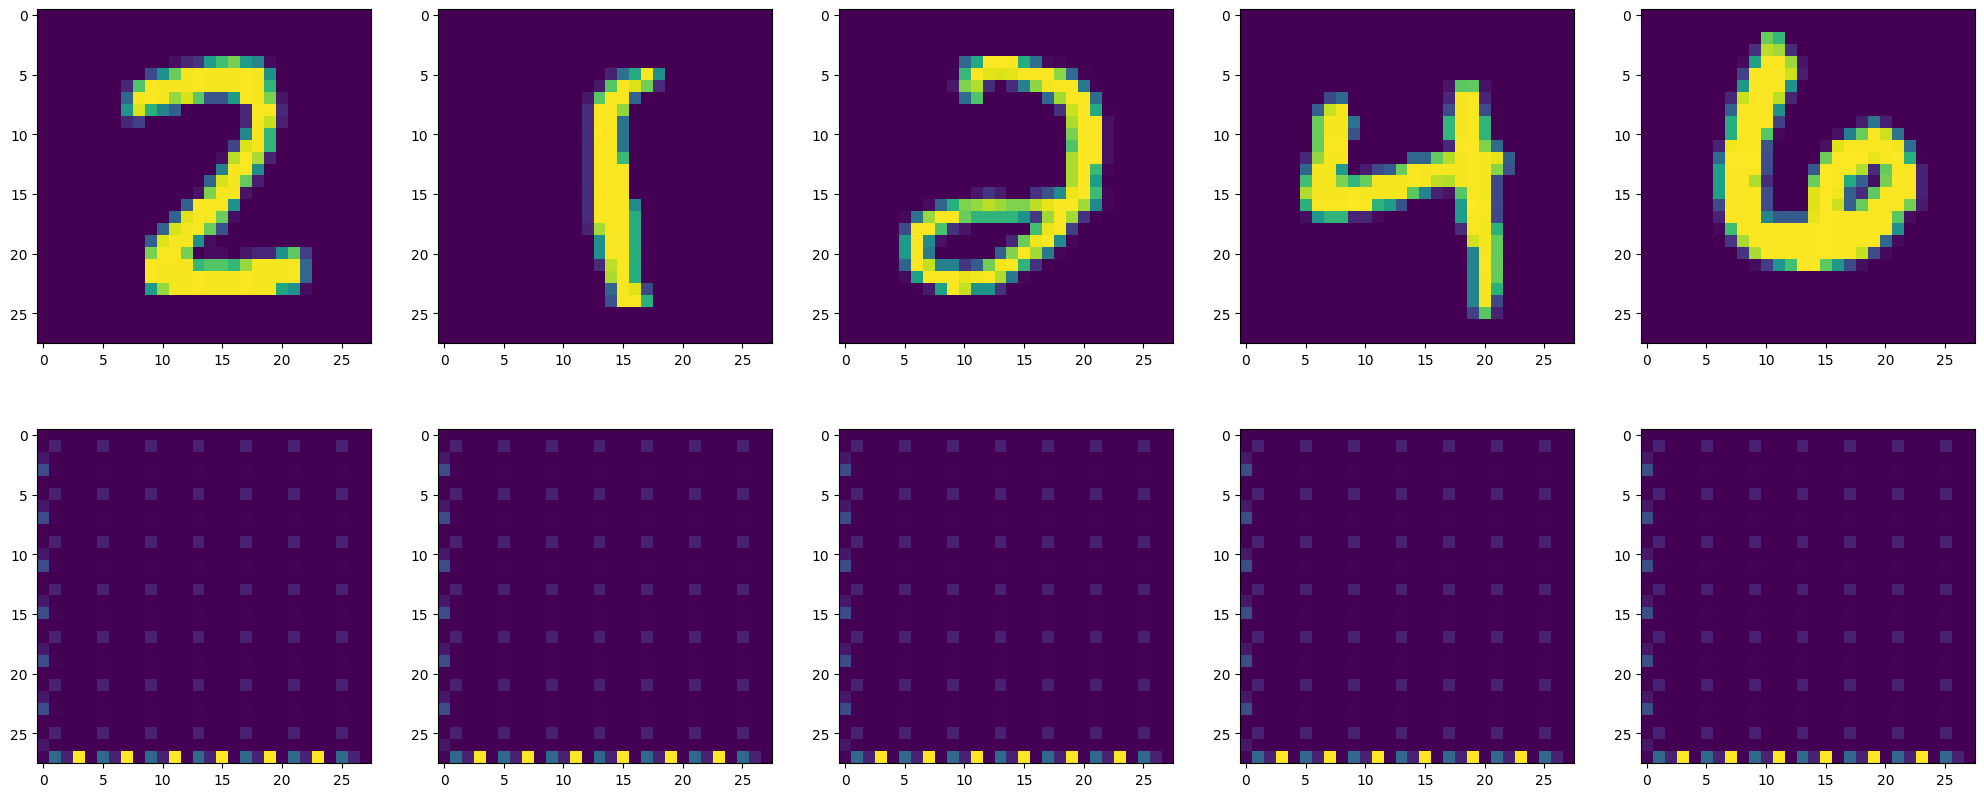

In [60]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/lat_losses/mapping_3_128_cosine.pth")

In [71]:
args = AttributeDict()
args.apply_augment = False
args.apply_masking = False
args.noise_lantents = False
args.apply_rec_loss = False
args.adv_loss_used = False
args.rec_loss_scale = 0.


mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)

l1_loss_hist = train_latent_map(
    mapping, 
    generator=G, 
    encoder=E, 
    loss_fn=F.l1_loss,
    optimizer=optimizer, 
    num_iters=num_iters, 
    batch_size=batch_size,
    args=args
)

torch.save(mapping.state_dict(), f"models/lat_losses/mapping_{n_hidden}_{hidden_dim}_l1.pth")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:59<00:00, 27.90it/s, loss=0.768]


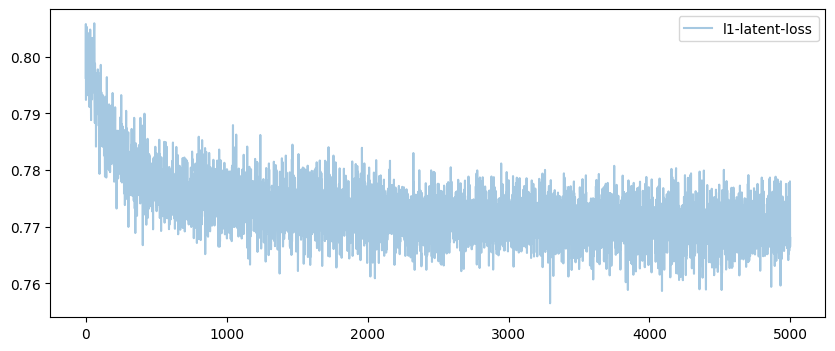

In [78]:
plot_losses({"l1-latent-loss": l1_loss_hist})

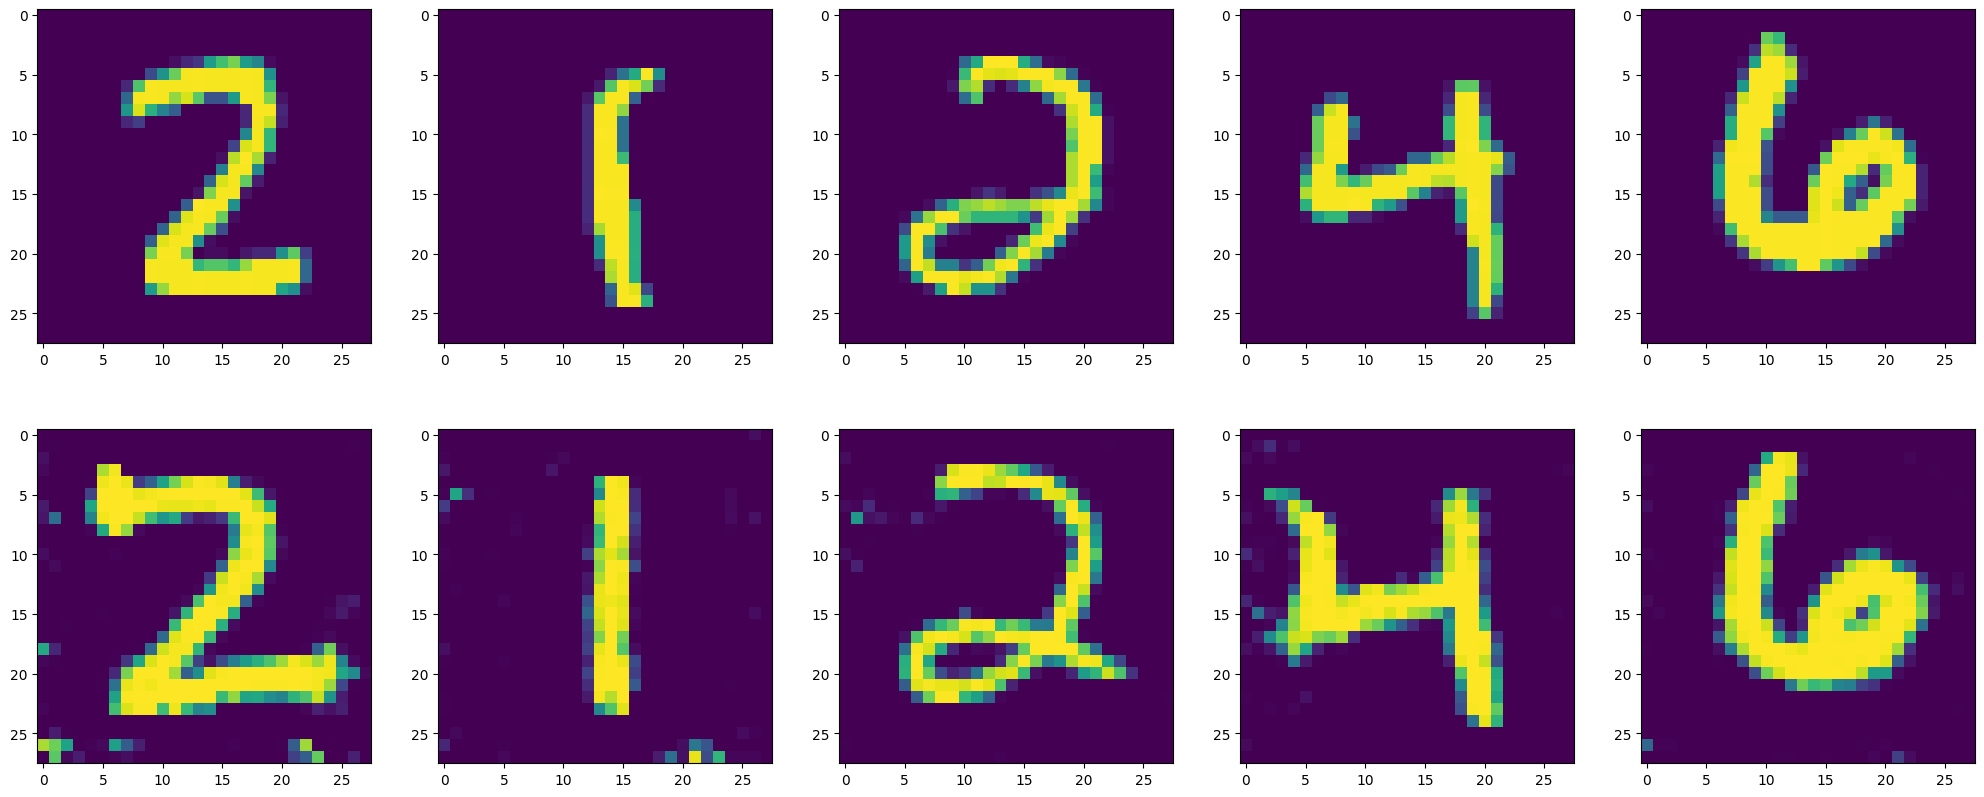

In [72]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/lat_losses/mapping_3_128_l1.pth")

### Trying adding reconstruction loss on images

$L = L_{latent}(\hat z, z) + c \cdot L_{rec}(G(\hat z), G(z))$, both losses are MSE in general

Result: in general seems to reduce noisy pixels around numbers and make reconstruction more precise

In [40]:
coefs = [0.1, 0.5, 1.]
loss_hists = {}
for c in coefs:
    args = AttributeDict()
    args.apply_augment = False
    args.apply_masking = False
    args.noise_lantents = False
    args.apply_rec_loss = True
    args.rec_loss_scale = c
    
    mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
    optimizer = optim.Adam(mapping.parameters(), lr=1e-4)
    
    loss_hist = train_latent_map(
        mapping, 
        generator=G, 
        encoder=E, 
        loss_fn=F.mse_loss,
        loss_rec=F.mse_loss,
        optimizer=optimizer, 
        num_iters=num_iters, 
        batch_size=batch_size,
        args=args
    )
    loss_hists[c] = loss_hist
    torch.save(mapping.state_dict(), f"models/rec_loss/mapping_{n_hidden}_{hidden_dim}_{c}.pth")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:37<00:00, 14.82it/s, loss=1.07]


In [ ]:
plt.figure(figsize=(10, 4))
for ns, loss_hist in loss_hists.items():
    plt.plot(range(len(loss_hist)), loss_hist, label=ns, alpha=0.4)
plt.legend()
plt.show()

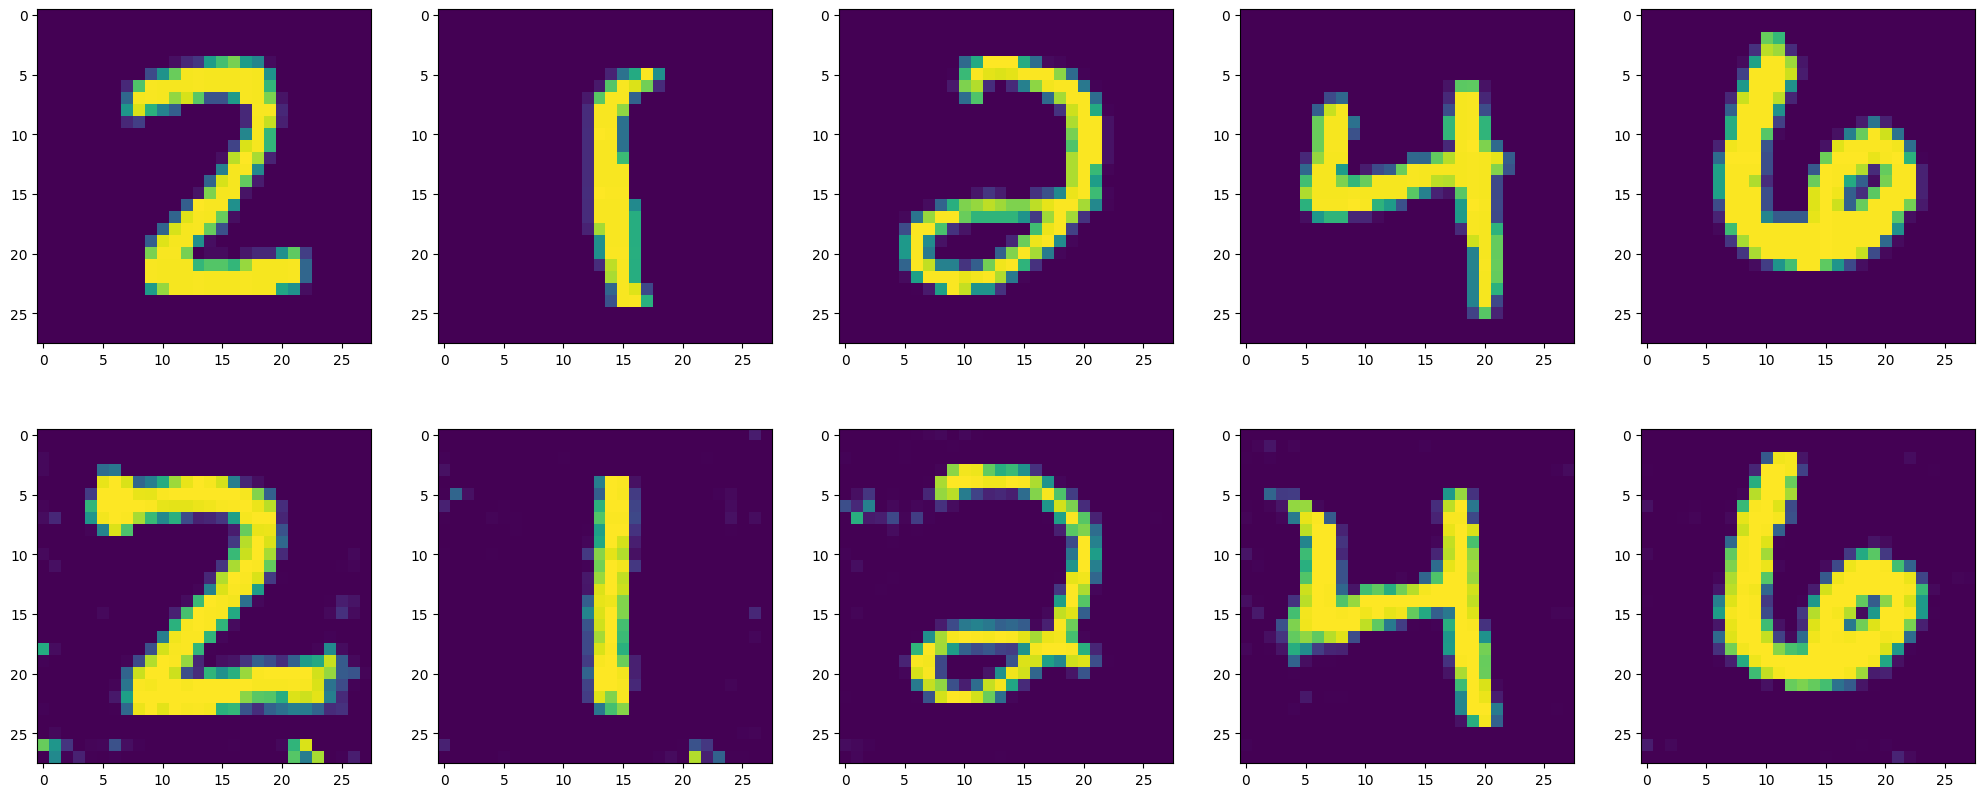

In [41]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/rec_loss/mapping_3_128_0.1.pth")

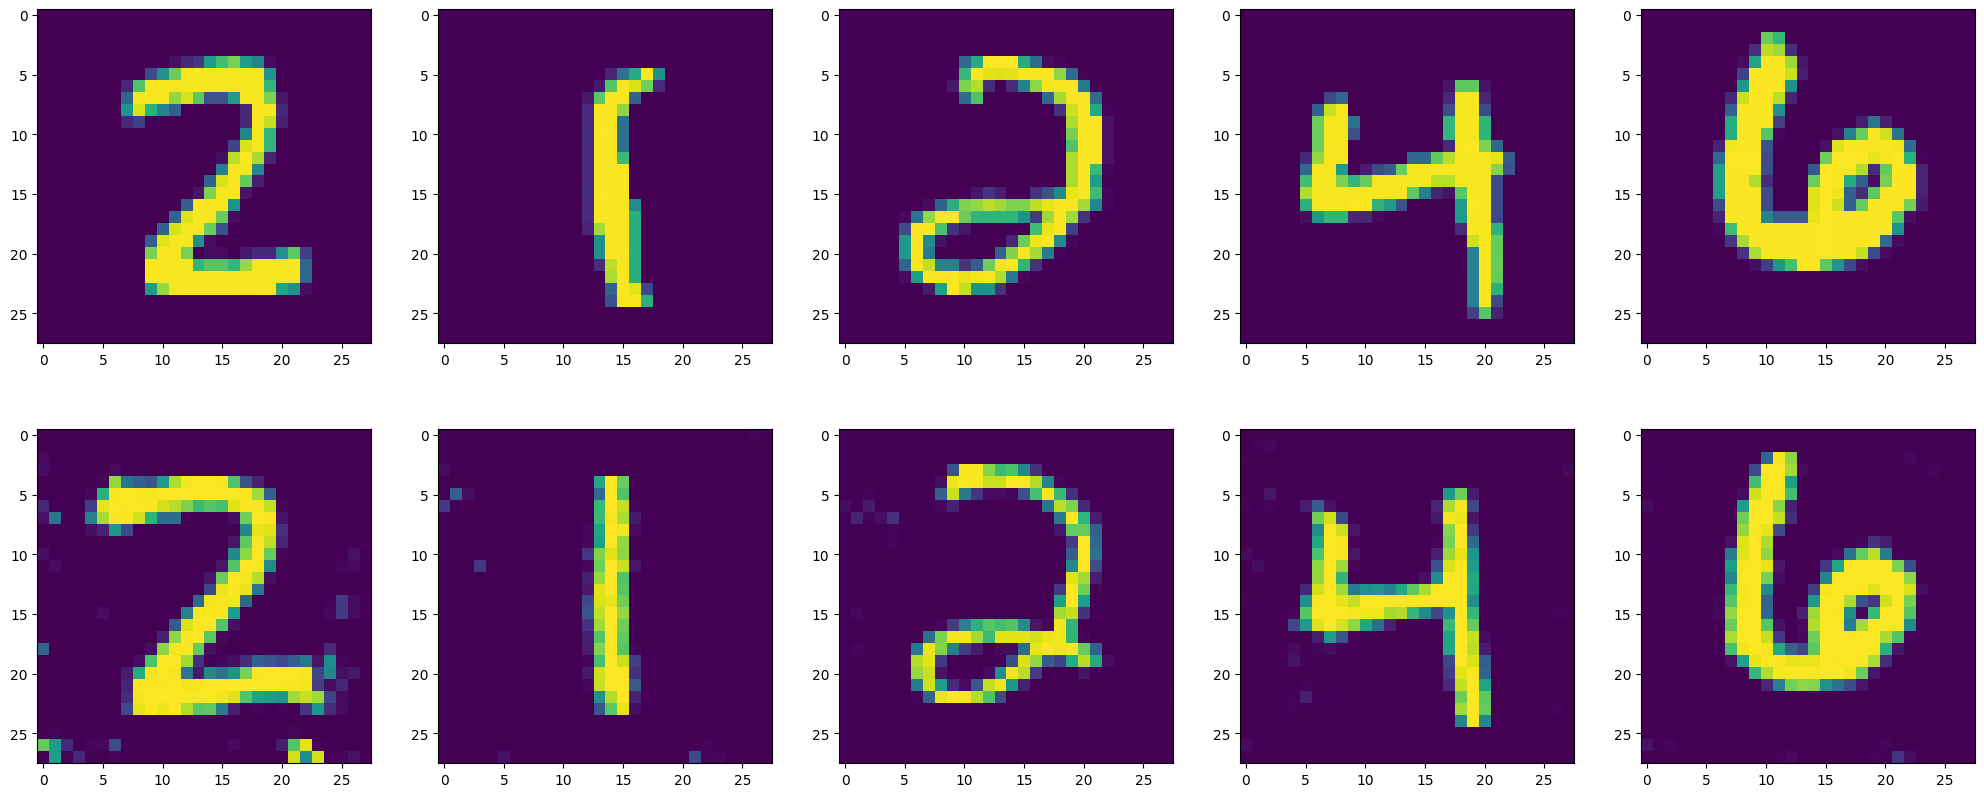

In [42]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/rec_loss/mapping_3_128_0.5.pth")

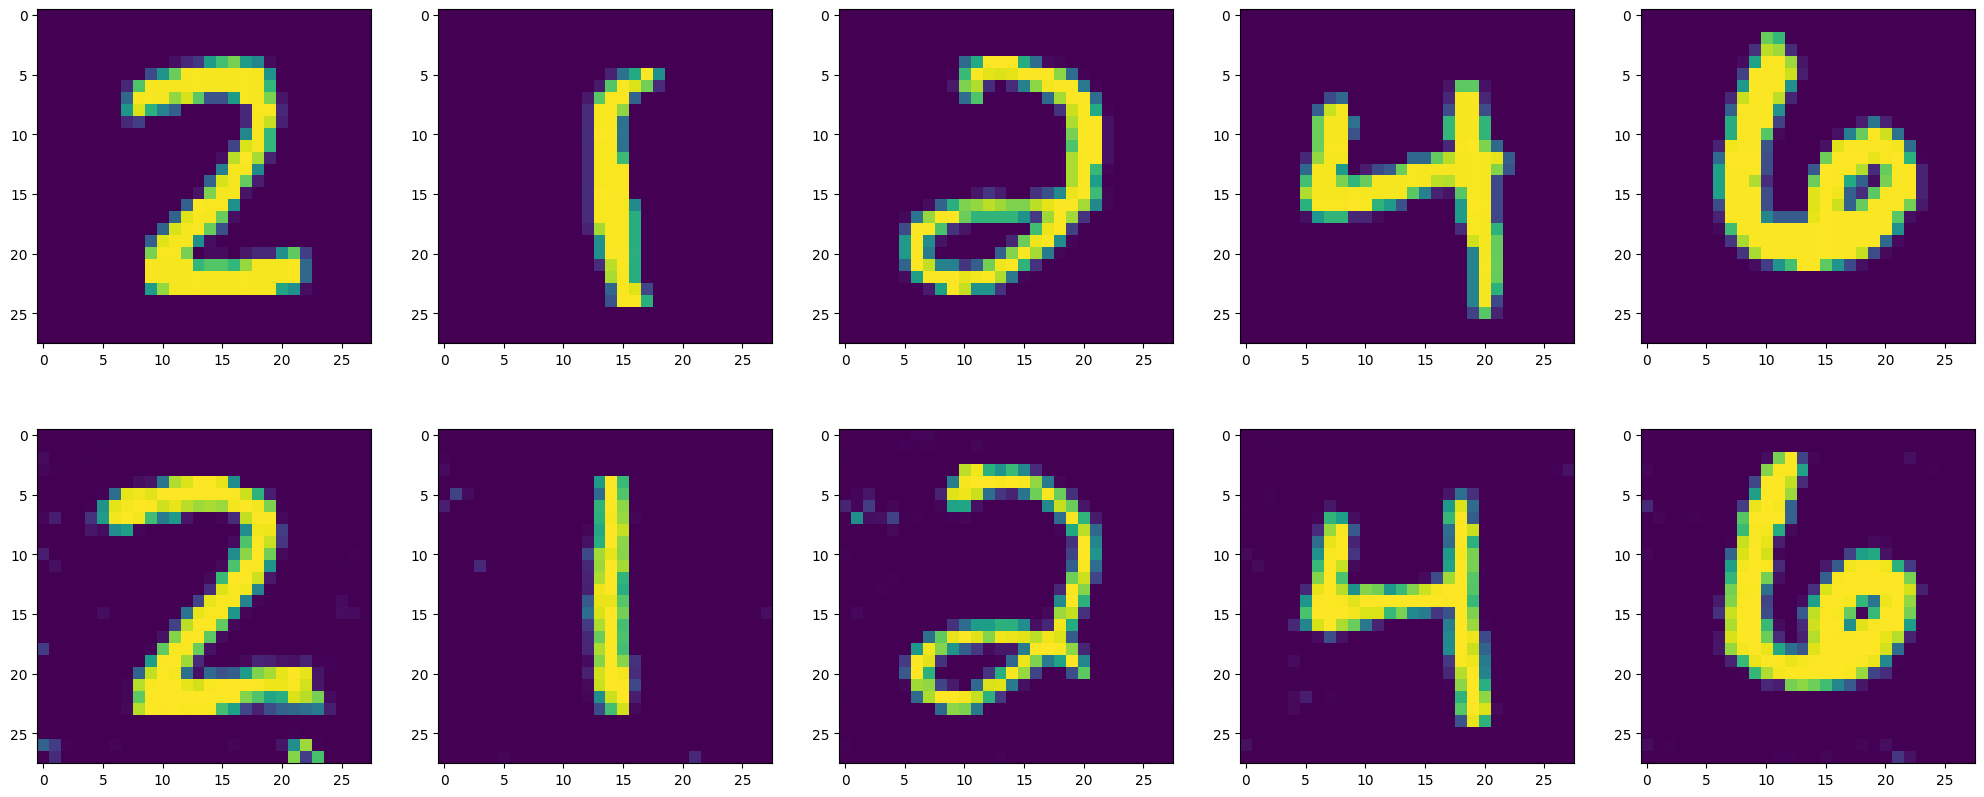

In [44]:
visualize_inversion(eval_samples, mapping, saved_weights_path="models/rec_loss/mapping_3_128_1.0.pth")

### Trying different noising scales

Result: doesn't seem to affect end-quality, for larger scales make things worse 

In [22]:
import random
num_iters=5000
batch_size=256
n_hidden=3
hidden_dim=128

args = AttributeDict()
args.apply_augment = False
args.apply_masking = False
args.noise_lantents = True
args.apply_rec_loss = False

loss_hists = {}
for ns in [0.01, 0.05, 0.1, 0.3, 0.5]:
    args.nl_scale = ns
    
    mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
    optimizer = optim.Adam(mapping.parameters(), lr=1e-4)
    
    loss_hist = train_latent_map(
        mapping, 
        generator=G, 
        encoder=E, 
        loss_fn=F.mse_loss,
        loss_rec=F.mse_loss,
        optimizer=optimizer, 
        num_iters=num_iters, 
        batch_size=batch_size,
        args=args
    )
    loss_hists[ns] = loss_hist
    torch.save(mapping.state_dict(), f"models/latent_noise_scale/mapping_{n_hidden}_{hidden_dim}_{ns}.pth")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:06<00:00, 26.76it/s, loss=0.937]


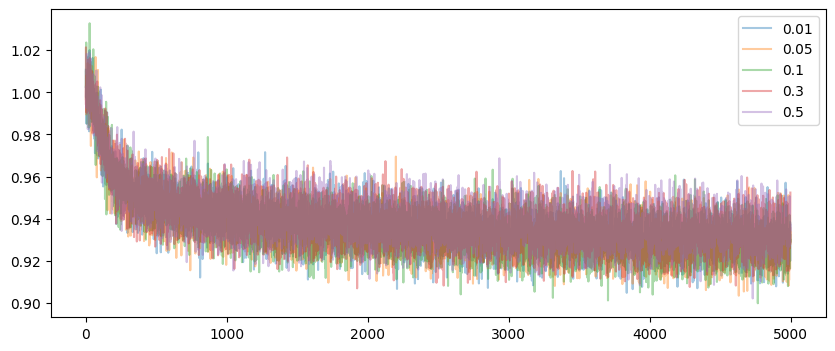

In [38]:
# plot lost hists
plt.figure(figsize=(10, 4))
for ns, loss_hist in loss_hists.items():
    plt.plot(range(len(loss_hist)), loss_hist, label=ns, alpha=0.4)
plt.legend()
plt.show()

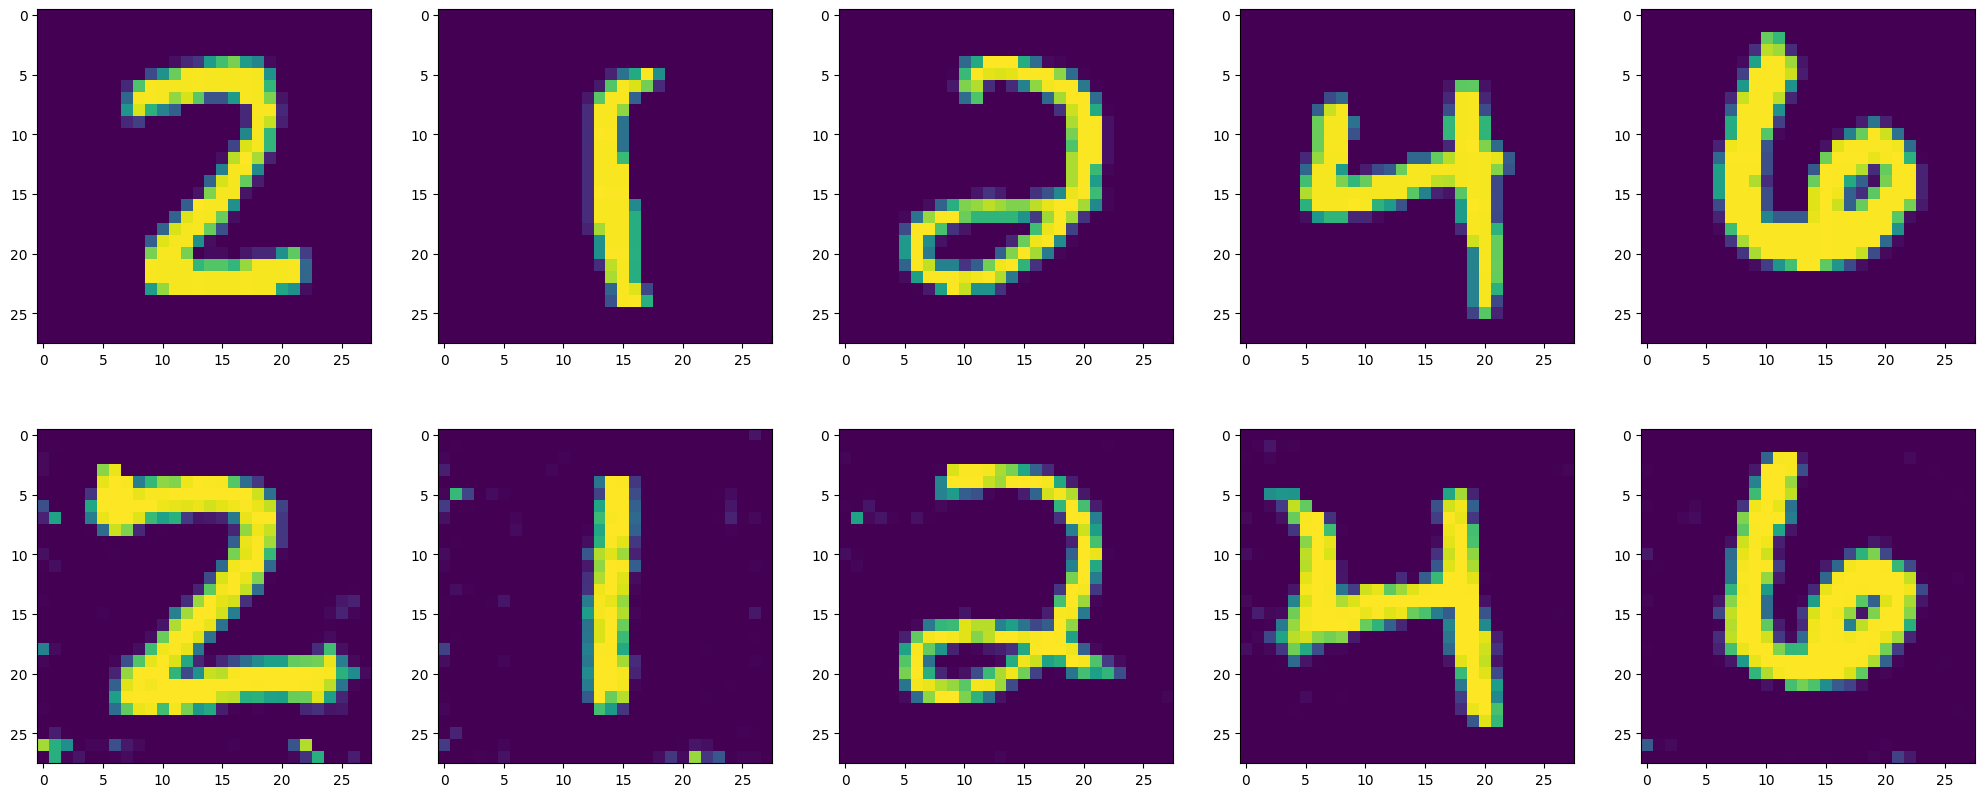

In [26]:
visualize_inversion(eval_samples, mapping, "models/latent_noise_scale/mapping_3_128_0.01.pth")

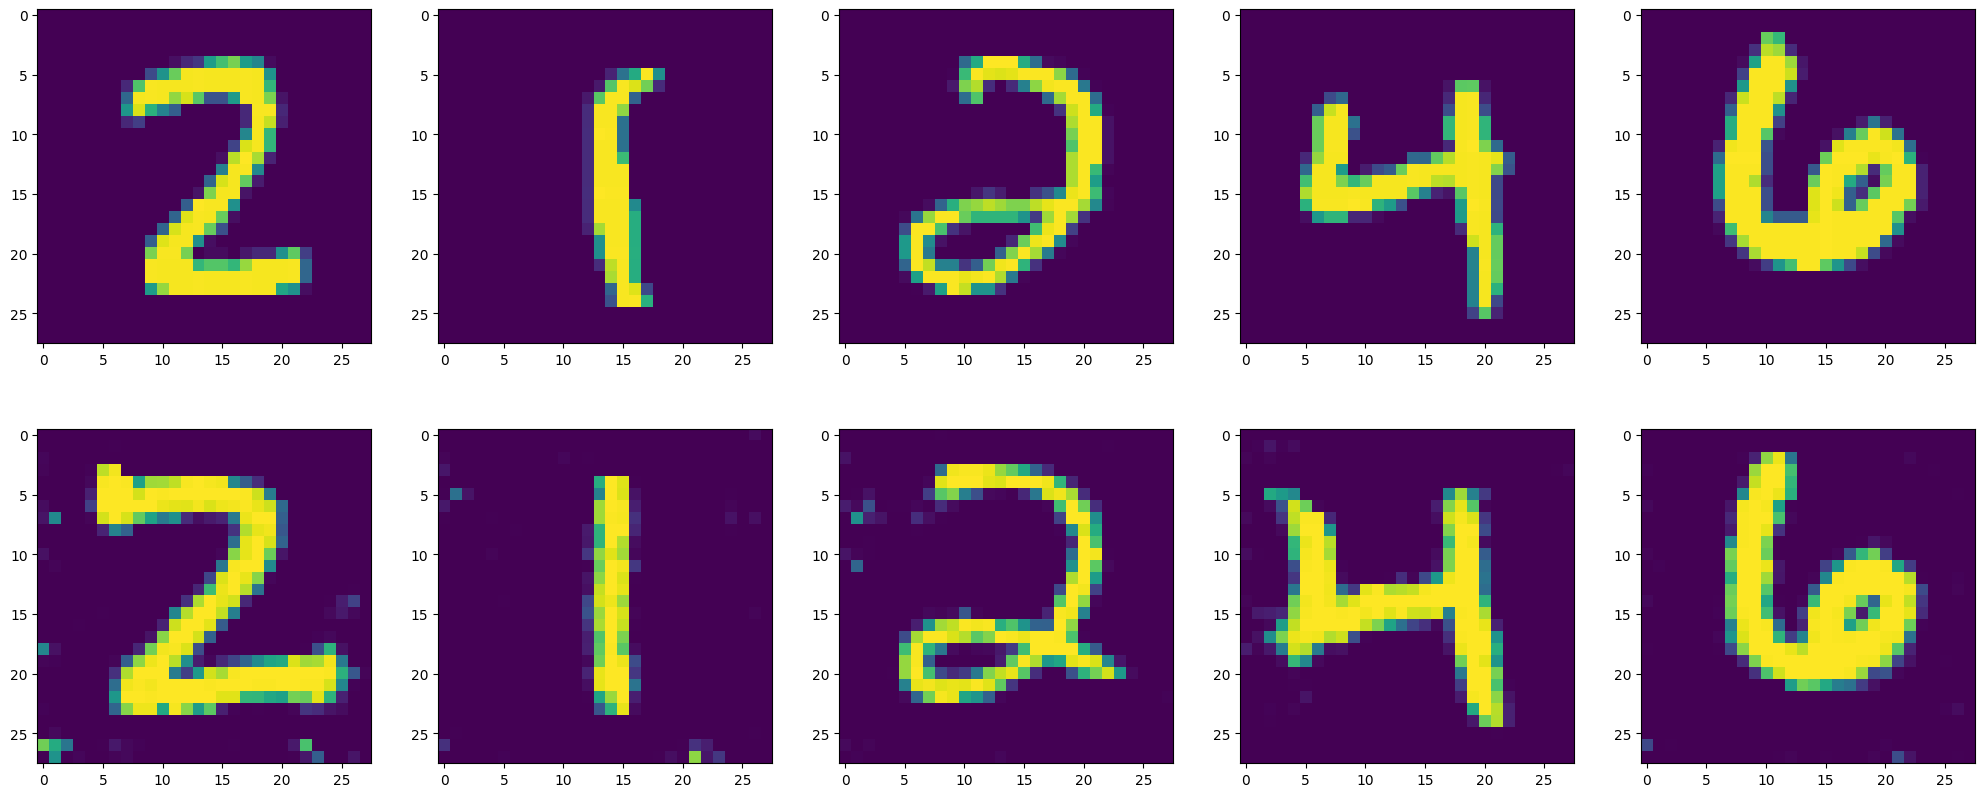

In [27]:
visualize_inversion(eval_samples, mapping, "models/latent_noise_scale/mapping_3_128_0.05.pth")

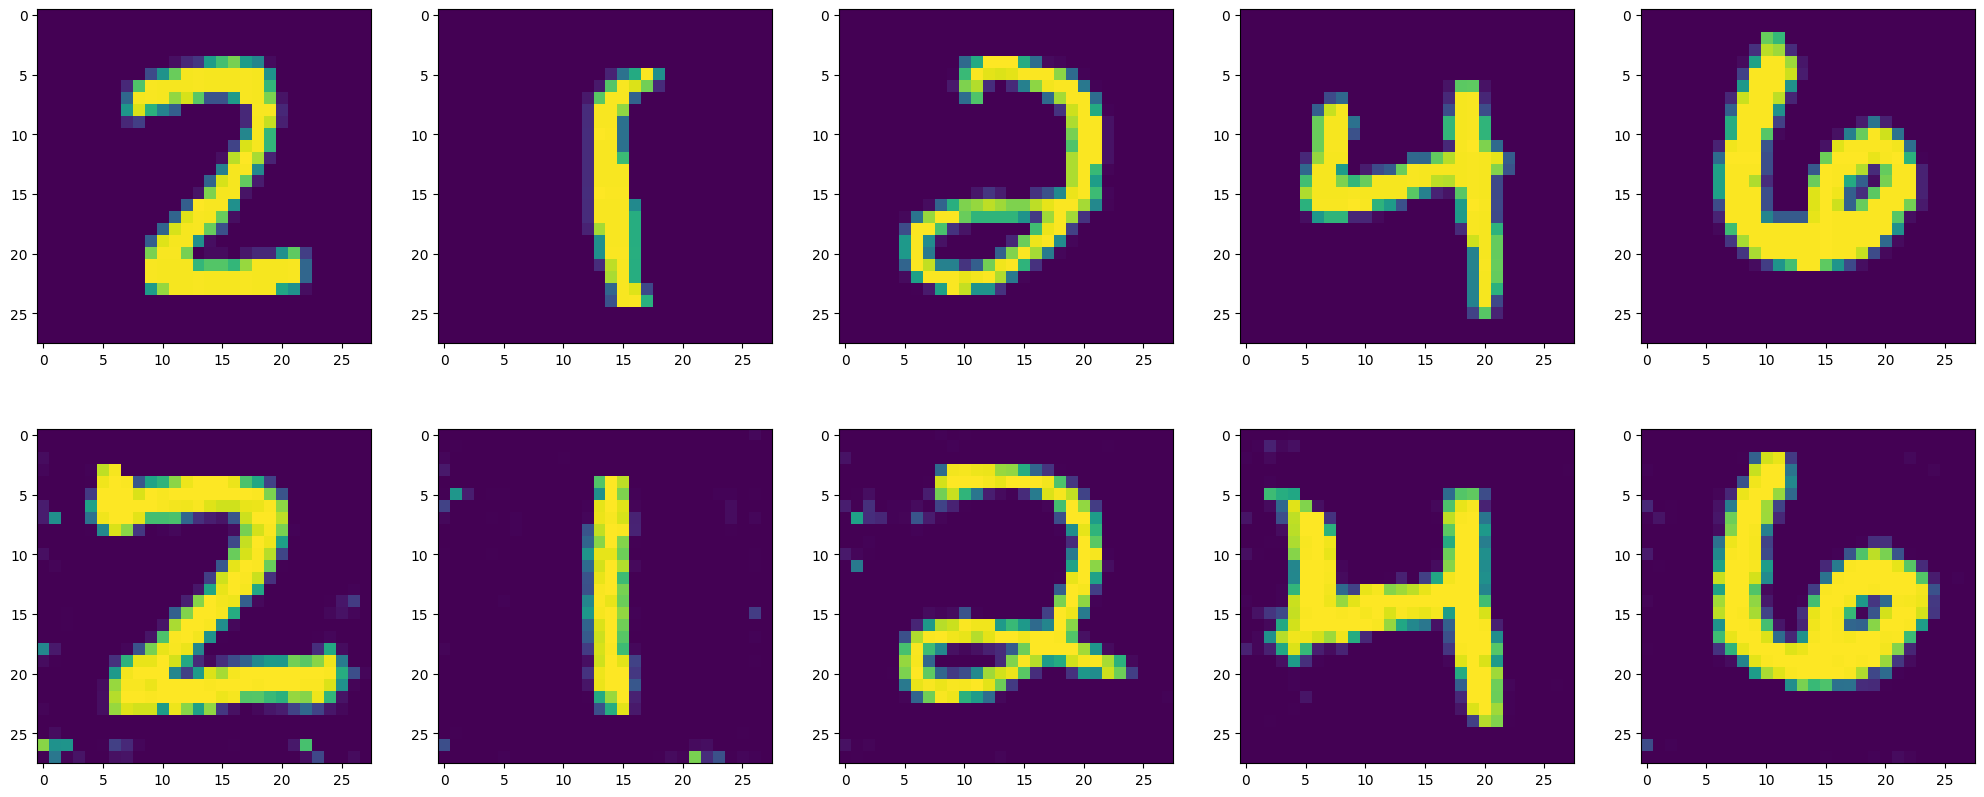

In [28]:
visualize_inversion(eval_samples, mapping, "models/latent_noise_scale/mapping_3_128_0.1.pth")

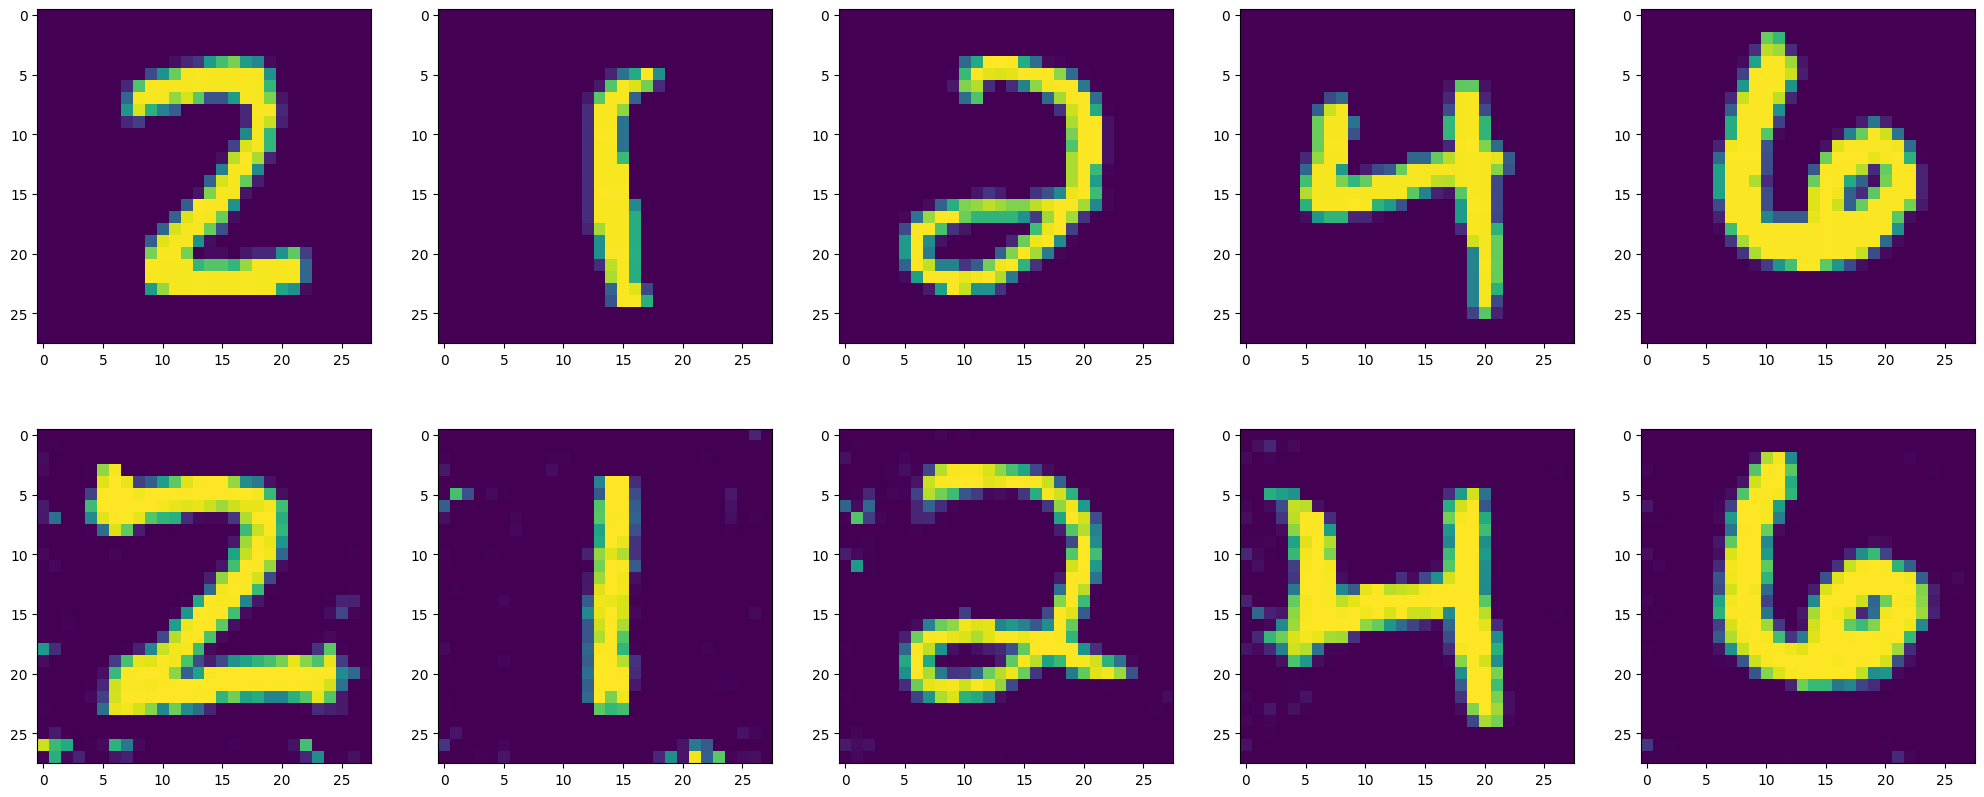

In [29]:
visualize_inversion(eval_samples, mapping, "models/latent_noise_scale/mapping_3_128_0.3.pth")

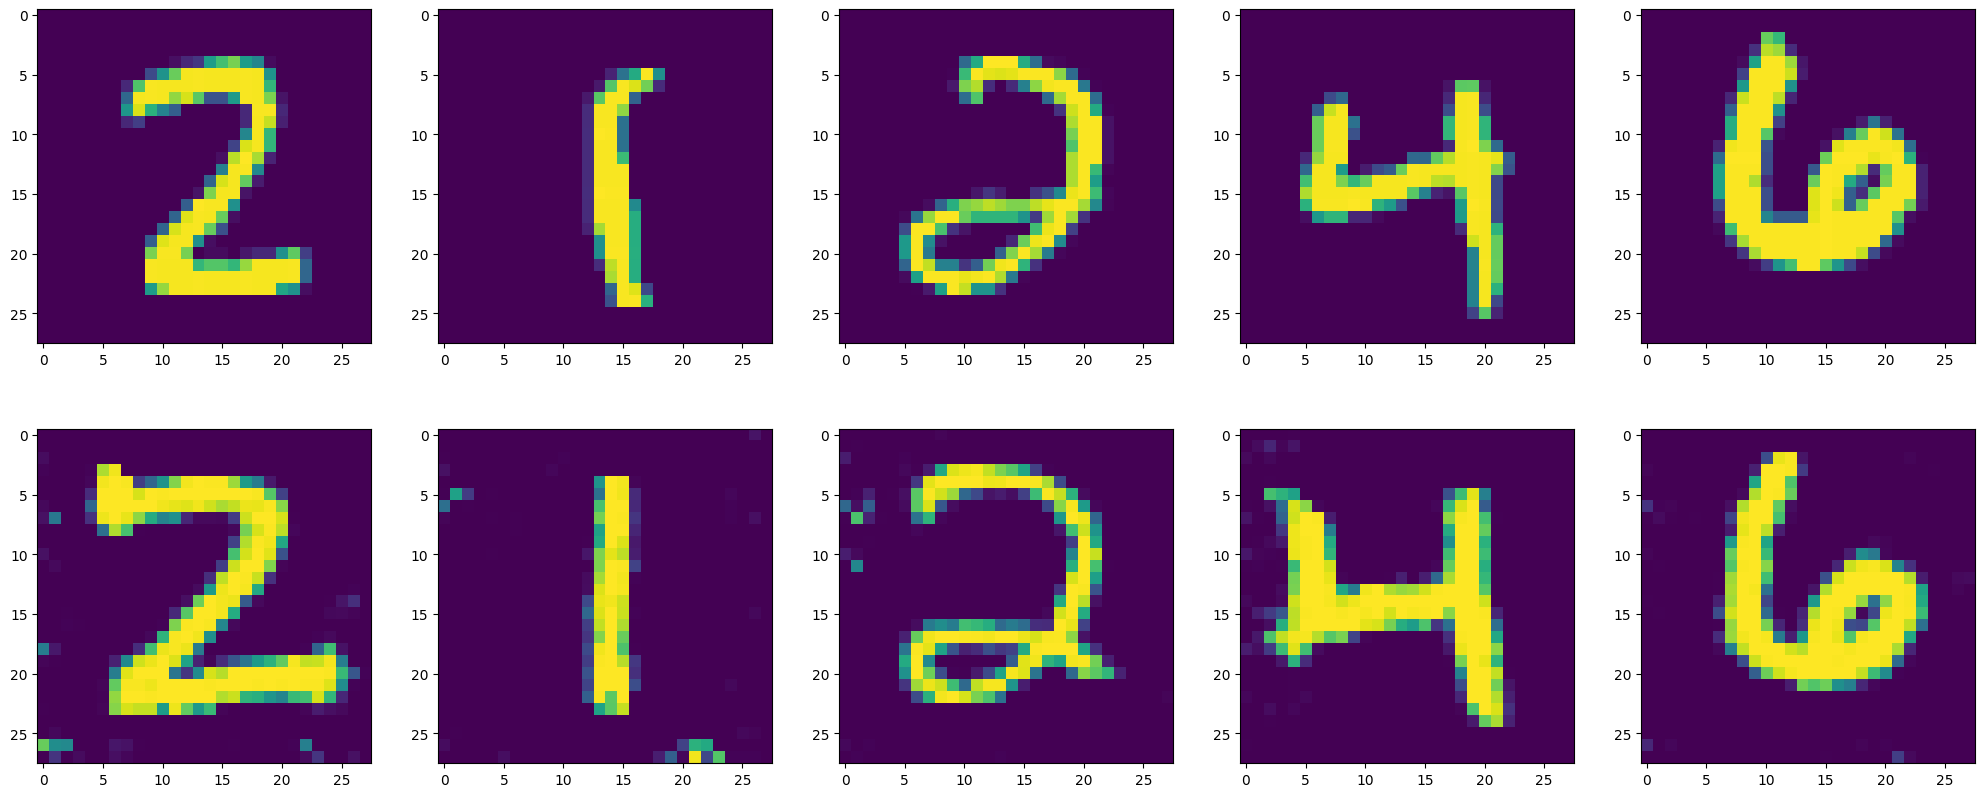

In [30]:
visualize_inversion(eval_samples, mapping, "models/latent_noise_scale/mapping_3_128_0.5.pth")

### Visualization of baseline

In [6]:
# check on other random samples
eval_samples = torch.stack([holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]).to(DEVICE)
_, axs = plt.subplots(2, 5, figsize=(25, 10))
mapping.eval()
with torch.no_grad():
    y = E(eval_samples).squeeze()
    z_hat = mapping(y)[:,:, None, None]
    inv_samples = G(z_hat)

for i in range(5):
    img_orig = eval_samples[i].cpu().numpy().reshape((28, 28))
    img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
    axs[0][i].imshow(img_orig)
    axs[1][i].imshow(img_invers)
plt.show()

NameError: name 'holdout_mnist' is not defined

### Latent interpolation in z-space and  y-space

Additionally we want to explore if our learned map $m(\cdot)$ allows for nice latent interpolations. 

That is, given a pair of images $(x_1, x_2)$, we want to traverse linear interpolation between $y_1 = enc(x_1)$ and $y_2 = enc(x_2)$ and by generating from $m(y_k)$ intermideate step $k$. 

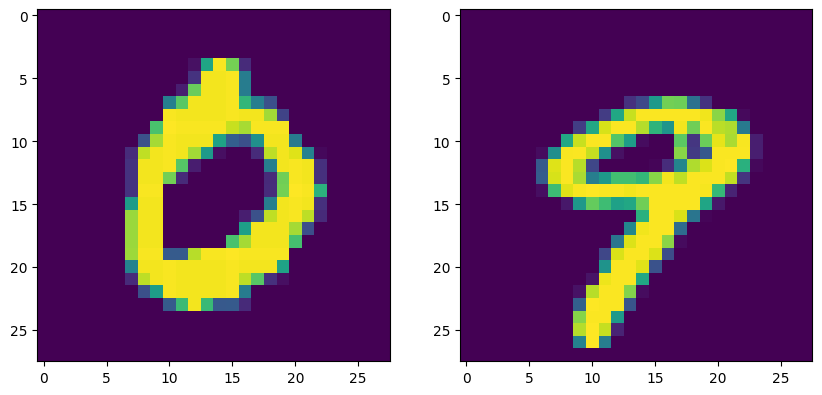

In [144]:
# 2, 6 - 1 and 4, similar, z-interpolation is better (guess their regions are connected)
# 3, 9 - 0 and 9, rather different, y-interpolation is better
i1, i2 = 3, 9
img1, img2 = holdout_mnist[i1][0], holdout_mnist[i2][0]

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1.reshape(28, 28))
axs[1].imshow(img2.reshape(28, 28))
plt.show()

In [145]:
y1, y2 = E(img1[None, :].cuda()), E(img2[None, :].cuda())

k=9
interpolations = [y1]
for a in range(1, k):
    interpolations.append(y1 + a*(y2 - y1)/k)
interpolations.append(y2)

In [146]:
mapping.eval()
images = []
for y_k in interpolations:
    with torch.no_grad():
        z_k = mapping(y_k.squeeze()[None, :])
        img_k = G(z_k[:, :, None, None])
    images.append(img_k.detach().cpu().numpy().squeeze())
    

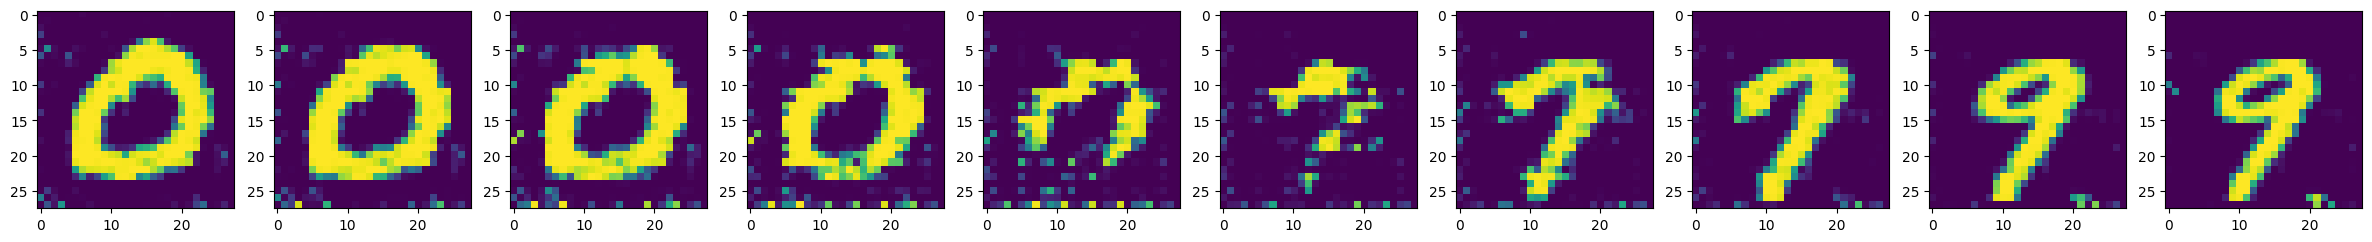

In [147]:
_, axs = plt.subplots(1, 10, figsize=(30, 3))
for (ax, img) in zip(axs, images):
    ax.imshow(img)
plt.show()

Let's compare interpolating in z-space directly 

In [148]:
# comparison to inperpolating in z-space
z1, z2 = mapping(y1.squeeze()[None, :]), mapping(y2.squeeze()[None, :])

k=9
z_interpolations = [z1]
for a in range(1, k):
    z_interpolations.append(z1 + a*(z2 - z1)/k)
z_interpolations.append(z2)

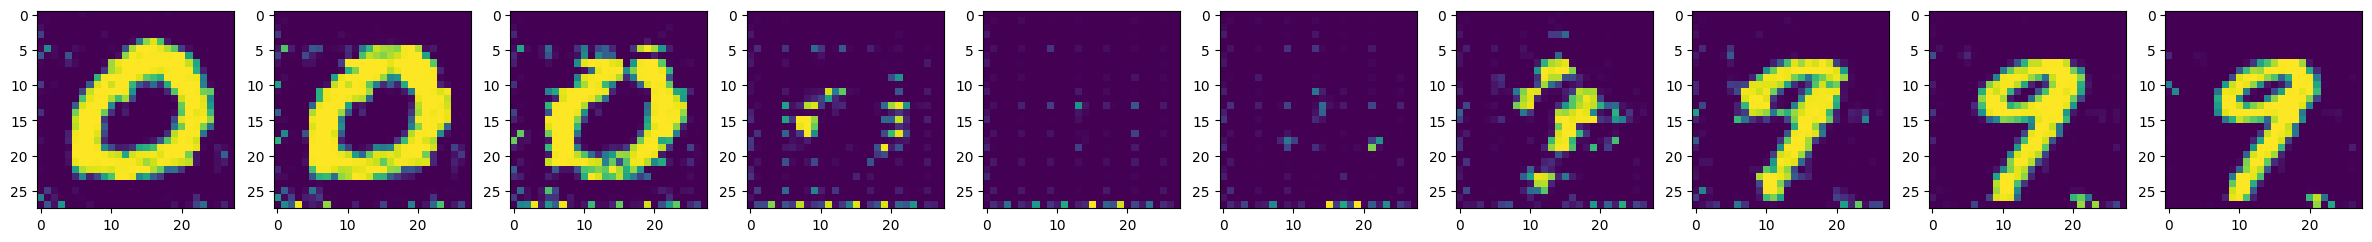

In [149]:
images = []
for z_k in z_interpolations:
    with torch.no_grad():
        img_k = G(z_k[:, :, None, None])
    images.append(img_k.detach().cpu().numpy().squeeze())

_, axs = plt.subplots(1, 10, figsize=(30, 3))
for (ax, img) in zip(axs, images):
    ax.imshow(img)
plt.show()

## Trying to fit map with CLIP-image encoder

Training custom encoder on same data domain is fine, but ideally we would like to utilize some big pretrained thing with good embeddings for the suppoert of generation model. Let's try this with CLIP

In [24]:
import clip

In [25]:
model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [26]:
holdout_mnist = MNIST(root="data", train=False, download=True)
image = holdout_mnist[0][0]
image_input = preprocess(image).unsqueeze(0).to(DEVICE)
with torch.no_grad():
    image_feature = model.encode_image(image_input)
image_feature /= image_feature.norm()

In [28]:
z_dim=100
y_dim=512
G = Generator().to(DEVICE)
G.load_state_dict(torch.load("models/mnist_gan.pth"))
G.requires_grad_(False)         

n_hidden=4
hidden_dim=256
mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=3e-3)
loss_fn = F.mse_loss

In [30]:
class BroadcastChannelTransform(object): # used to broadcast mnist image tensors
    def __init__(self, output_ch=3):
        self.output_ch = output_ch

    def __call__(self, images: torch.Tensor):
        if len(images.shape) == 4:
            bs, _, h, w = images.shape
            return images.broadcast_to((bs, self.output_ch, h, w))
        else:
            image = images
            _, h, w = image.shape
            return image.broadcast_to(self.output_ch, h, w)
        
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean=0.5, std=0.5):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
    
denormalize = NormalizeInverse()

In [31]:
n_px=model.visual.input_resolution
clip_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    BroadcastChannelTransform(3),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

In [32]:
to_pil = T.ToPILImage()
num_iters=500
bs=256

G.eval()
model.eval()
mapping.train()
p_bar = tqdm(range(num_iters))
for i in p_bar:
    optimizer.zero_grad()
    z = torch.randn((bs, z_dim), device=DEVICE)
    with torch.no_grad():
        images = denormalize(G(z[:,:, None, None]))
        images = clip_transform(images)
        y = model.encode_image(images).squeeze(0).float()
    z_hat = mapping(y)
    loss = loss_fn(z_hat, z)
    loss.backward()
    optimizer.step()
    p_bar.set_description(f"loss: {loss.item():.5f}")

torch.save(mapping.state_dict(), f"models/mapping_clip_b_{n_hidden}_{hidden_dim}.pth")

  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\MQTyor\ai_pc\ENVS_general\cmpttv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
loss: 0.93895: 100%|██████████| 500/500 [01:38<00:00,  5.07it/s]


In [35]:
eval_samples = [holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]

eval_transform = T.Compose([
    T.Resize(n_px, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    T.CenterCrop(n_px),
    T.ToTensor(),
    BroadcastChannelTransform(3),
    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

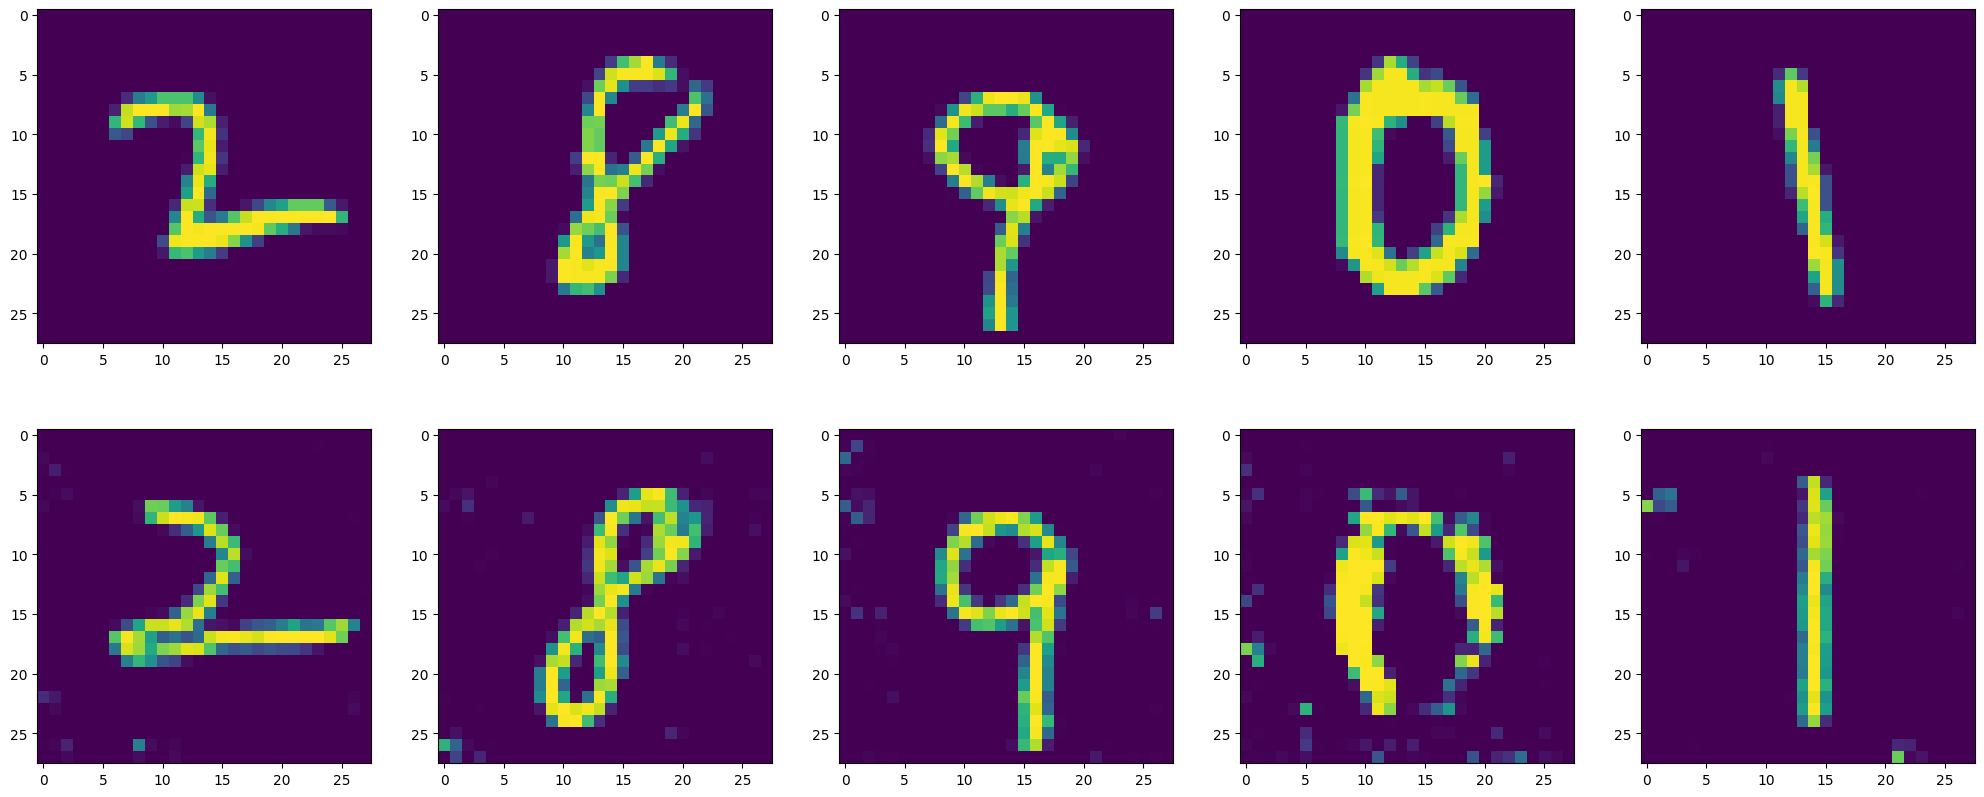

In [36]:
_, axs = plt.subplots(2, 5, figsize=(25, 10))
mapping.eval()
with torch.no_grad():
    images_test = torch.stack([eval_transform(img) for img in eval_samples]).to(DEVICE)
    y = model.encode_image(images_test).squeeze(0).float()
    z_hat = mapping(y)
    # print(list(mapping.projection[0].parameters()))
    inv_samples = G(z_hat[:, :, None, None])

for i in range(5):
    img_orig = np.array(eval_samples[i]).reshape((28, 28))
    img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
    axs[0][i].imshow(img_orig)
    axs[1][i].imshow(img_invers)
plt.show()

Adding masking 

In [64]:
def train_latent_map_clip(
        mapping: nn.Module, 
        generator: nn.Module, 
        encoder: nn.Module, 
        loss_fn, # loss function used on latents
        optimizer, 
        num_iters=5000, 
        eval_iters=1000, 
        batch_size=512, 
        loss_rec=None,
        ema=None,
        image_augmentations=None,
        args=AttributeDict()
    ):
    generator.eval()
    encoder.eval()
    mapping.train()

    loss_hist = []
    p_bar = tqdm(range(num_iters))
    for i in p_bar:
        optimizer.zero_grad()
        
        z = torch.randn((batch_size, z_dim), device=DEVICE)
        
        with torch.no_grad():
            images = denormalize(G(z[:,:, None, None]))
            if image_augmentations is not None:
                images = image_augmentations(images)
            images = clip_transform(images)
            y = encoder.encode_image(images).squeeze(0).float()

            if args.noise_lantents:
                y += args.nl_scale*torch.randn_like(y)
        if args.adv_loss_used:
            loss = loss_fn(mapping, y, z)
        else:
            z_hat = mapping(y)
            loss = loss_fn(z_hat, z)
        if loss_rec is not None:
            imgs_hat = G(z_hat[:, :, None, None])
            loss += args.rec_loss_scale * loss_rec(imgs_hat, images)
        
        loss.backward()
        optimizer.step()
        # if ema is not None:
        #     ema.update()
        
        loss_hist.append(loss.item())
        p_bar.set_postfix(loss=loss.item())

    return loss_hist, mapping


@torch.no_grad()
def visualize_inversion_clip(eval_samples, mapping, encoder, images, saved_weights_path=None):
    if saved_weights_path is not None:
        mapping.load_state_dict(torch.load(saved_weights_path))
    mapping.eval()
    y = encoder.encode_image(images).squeeze(0).float()
    z_hat = mapping(y)[:,:, None, None]
    inv_samples = G(z_hat)

    _, axs = plt.subplots(2, 5, figsize=(16, 6))
    for i in range(5):
        img_orig = np.array(eval_samples[i]).reshape((28, 28))
        img_invers = inv_samples[i].cpu().numpy().reshape((28, 28))
        axs[0][i].imshow(img_orig)
        axs[1][i].imshow(img_invers)
    plt.show()

In [60]:
from torchvision import transforms as T

args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 0. # loss(x, G(z))

mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)
batch_size = bs

masking_loss_hist, mapping = train_latent_map_clip(
    mapping, 
    generator=G, 
    encoder=model, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=500, 
    batch_size=batch_size,
    image_augmentations=T.RandomErasing(),
    args=args
)

torch.save(mapping.state_dict(), f"models/mapping_clip_b_{n_hidden}_{hidden_dim}_inpaint.pth")

  0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\MQTyor\ai_pc\ENVS_general\cmpttv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 500/500 [01:38<00:00,  5.09it/s, loss=0.966]


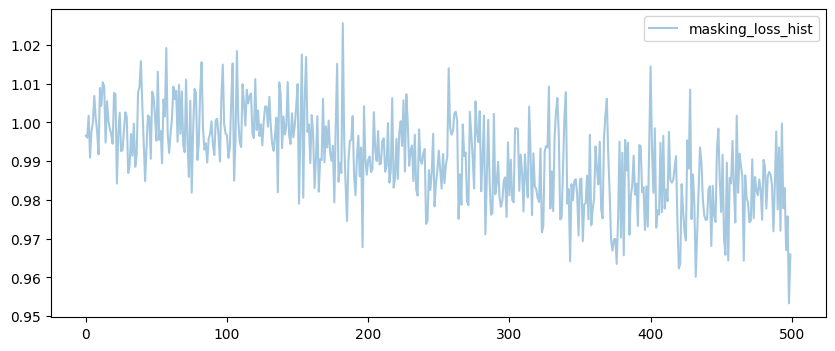

In [71]:
plot_losses({"masking_loss_hist": masking_loss_hist})

With inpainting

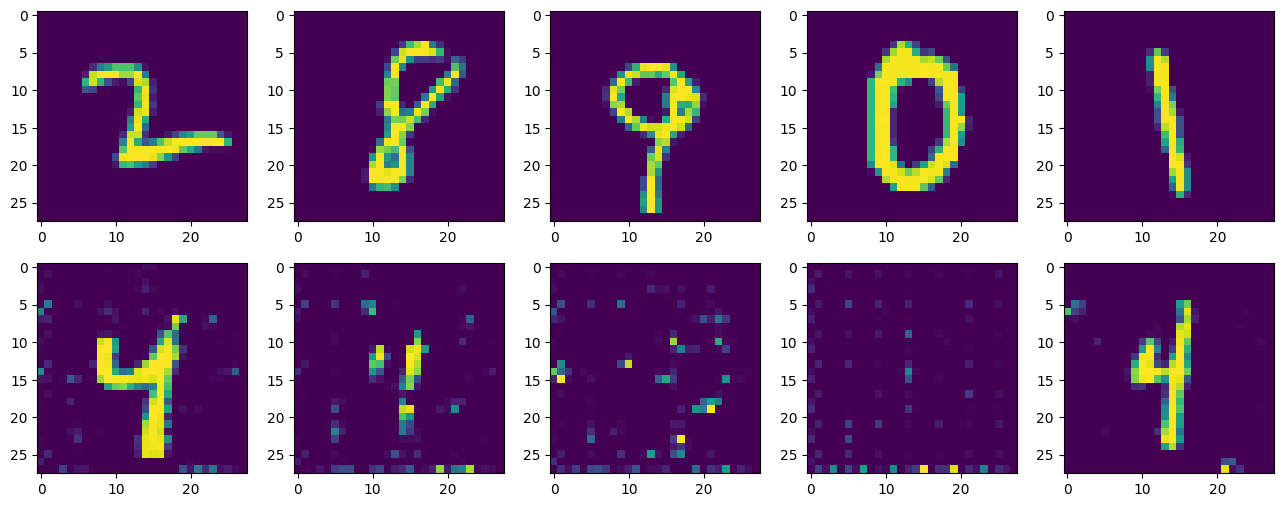

In [65]:
visualize_inversion_clip(eval_samples, mapping, encoder=model, images=images_test, saved_weights_path="models\mapping_clip_b_4_256_inpaint.pth")

Without inpainting

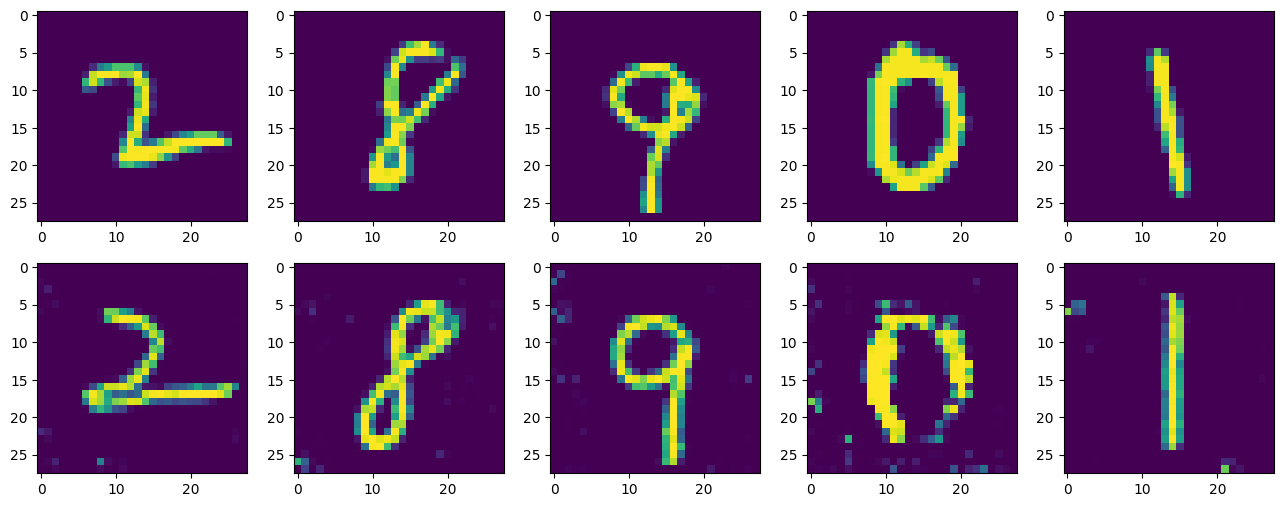

In [66]:
visualize_inversion_clip(eval_samples, mapping, encoder=model, images=images_test, saved_weights_path="models\mapping_clip_b_4_256.pth")

Training for more steps - 2000

  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\MQTyor\ai_pc\ENVS_general\cmpttv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2000/2000 [06:31<00:00,  5.11it/s, loss=0.989]


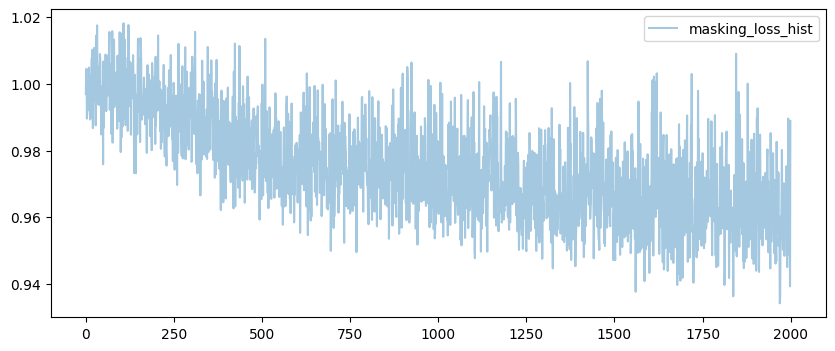

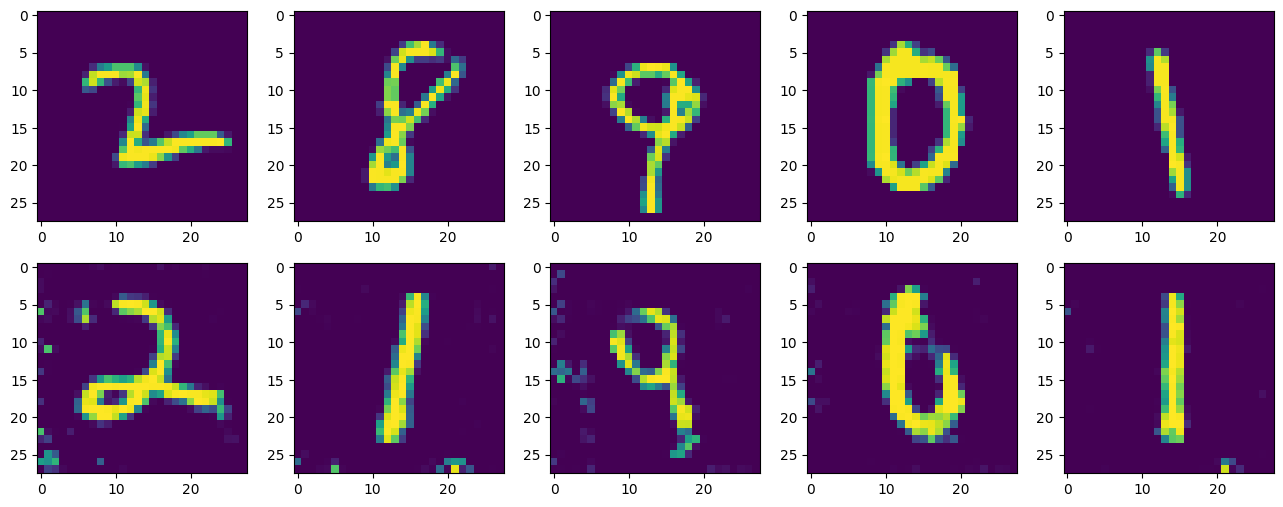

In [72]:
from torchvision import transforms as T

args = AttributeDict()
args.noise_lantents = False
args.adv_loss_used = False
args.rec_loss_scale = 0. # loss(x, G(z))

mapping = M(n_hidden, hidden_dim, y_dim, z_dim).to(DEVICE)
optimizer = optim.Adam(mapping.parameters(), lr=1e-4)
batch_size = bs

masking_loss_hist, mapping = train_latent_map_clip(
    mapping, 
    generator=G, 
    encoder=model, 
    loss_fn=F.mse_loss,
    optimizer=optimizer, 
    num_iters=2000, 
    batch_size=batch_size,
    image_augmentations=T.RandomErasing(),
    args=args
)

torch.save(mapping.state_dict(), f"models/mapping_clip_b_{n_hidden}_{hidden_dim}_inpaint_step2000.pth")
plot_losses({"masking_loss_hist": masking_loss_hist})
visualize_inversion_clip(eval_samples, mapping, encoder=model, images=images_test, saved_weights_path="models\mapping_clip_b_4_256_inpaint_step2000.pth")

The inpainting does not help generations

Interpolating 

In [109]:
# # 2, 6 - 1 and 4, similar, z-interpolation is better (guess their regions are connected)
# # 3, 9 - 0 and 9, rather different, y-interpolation is better
# i1, i2 = 3, 9
# img1, img2 = np.array(holdout_mnist[i1][0]), np.array(holdout_mnist[i2][0])

# _, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].imshow(img1.reshape(28, 28))
# axs[1].imshow(img2.reshape(28, 28))
# plt.show()

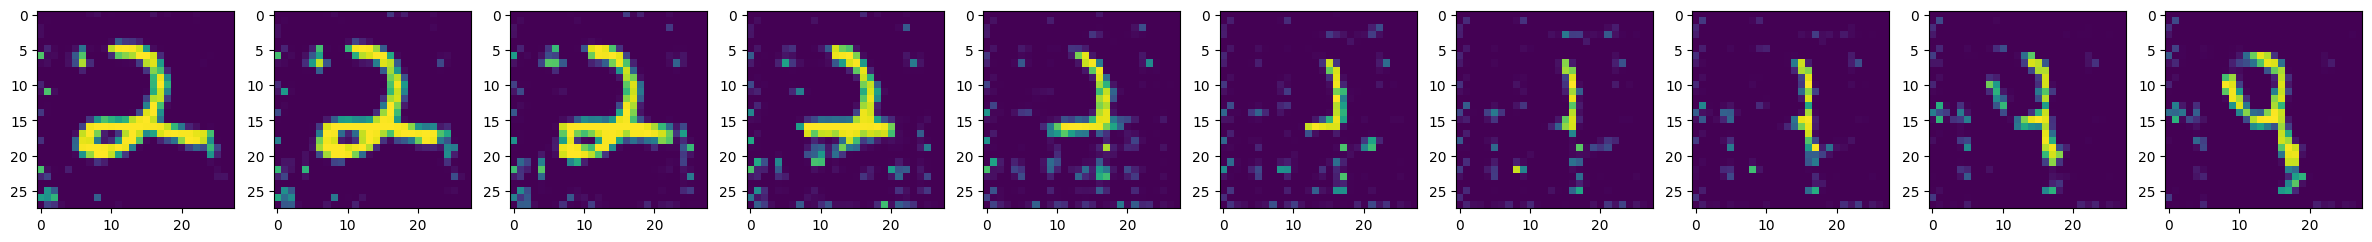

In [108]:
with torch.no_grad():
    y_list = model.encode_image(images_test).squeeze(0).float()    
    y1 = y_list[0]
    y2 = y_list[2]

    k=9
    interpolations = [y1]
    for a in range(1, k):
        interpolations.append(y1 + a*(y2 - y1)/k)
    interpolations.append(y2)

    mapping.eval()
    images = []
    for y_k in interpolations:
        with torch.no_grad():
            z_k = mapping(y_k.squeeze()[None, :])
            img_k = G(z_k[:, :, None, None])
        images.append(img_k.detach().cpu().numpy().squeeze())
        
    _, axs = plt.subplots(1, 10, figsize=(30, 3))
    for (ax, img) in zip(axs, images):
        ax.imshow(img)
    plt.show()

interpolation in mapped back to z representations

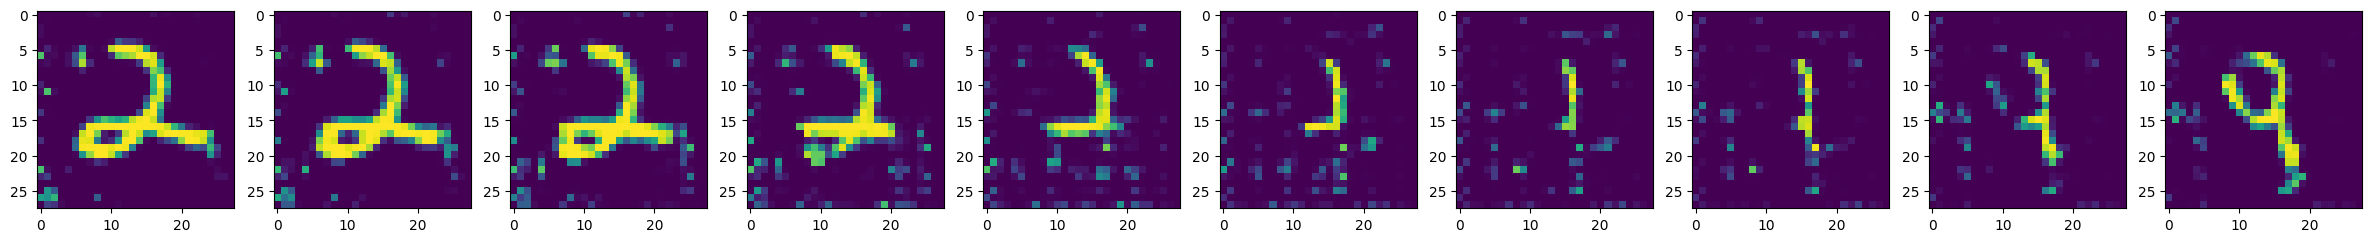

In [107]:
with torch.no_grad():
    # comparison to inperpolating in z-space
    z1, z2 = mapping(y1.squeeze()[None, :]), mapping(y2.squeeze()[None, :])

    k=9
    z_interpolations = [z1]
    for a in range(1, k):
        z_interpolations.append(z1 + a*(z2 - z1)/k)
    z_interpolations.append(z2)

    images = []
    for z_k in z_interpolations:
        with torch.no_grad():
            img_k = G(z_k[:, :, None, None])
        images.append(img_k.detach().cpu().numpy().squeeze())

    _, axs = plt.subplots(1, 10, figsize=(30, 3))
    for (ax, img) in zip(axs, images):
        ax.imshow(img)
    plt.show()

No difference